In [ ]:
! pip install modisco-lite
!pip install vizsequence
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [ ]:
import modiscolite
import vizsequence

import numpy as np
import sys
import os
import torch
import scipy
import h5py as h5
import matplotlib.pyplot as plt

from collections import OrderedDict
from importlib import reload

import dmslogo
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

class utils():
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

## Load CODA contributions

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
print(all_contributions.shape)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

torch.Size([3, 75000, 4, 200])


## Load a TF-MoDISco results file

###K562

-------------------------- pos_patterns --------------------------
pos_patterns: pattern_0


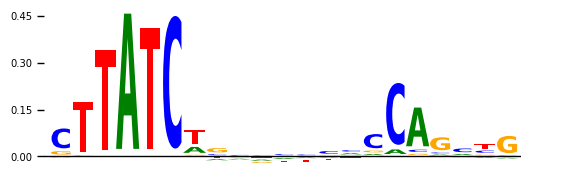

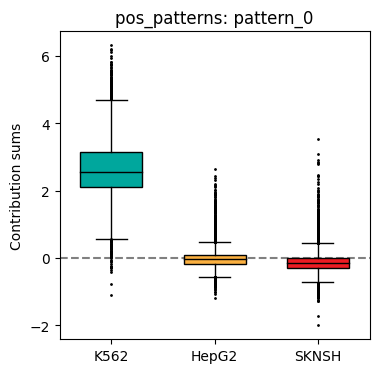


pos_patterns: pattern_1


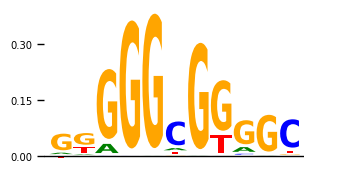

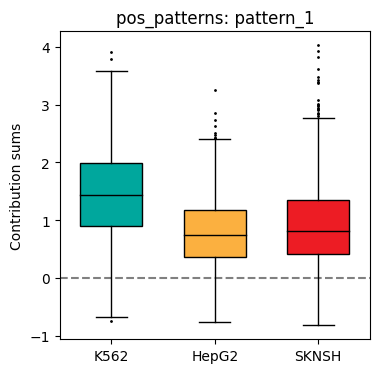


pos_patterns: pattern_10


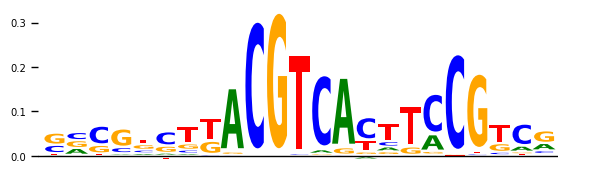

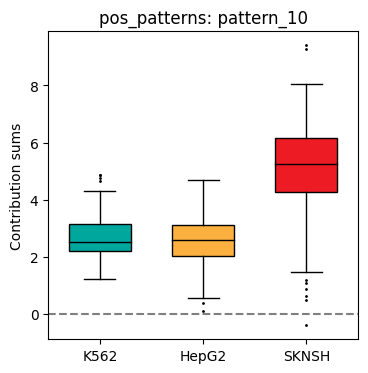


pos_patterns: pattern_11


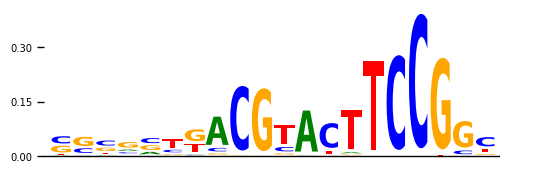

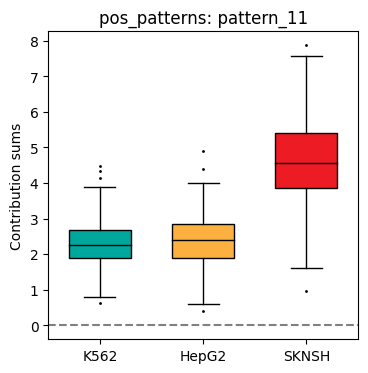


pos_patterns: pattern_12


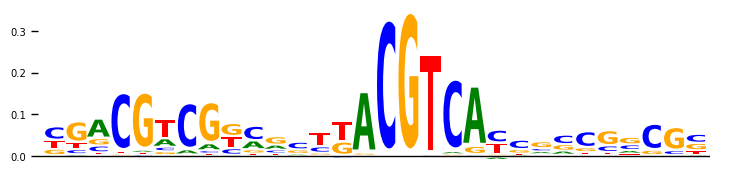

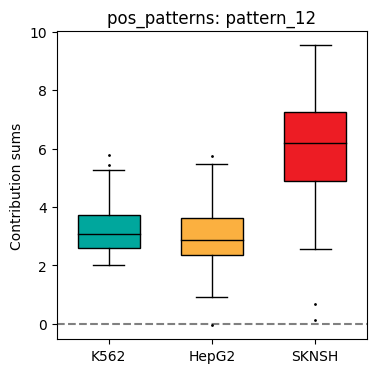


pos_patterns: pattern_13


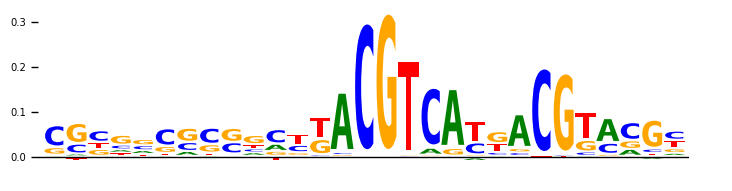

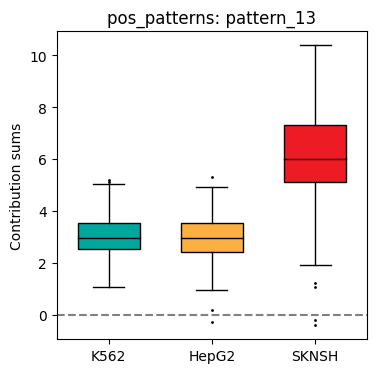


pos_patterns: pattern_14


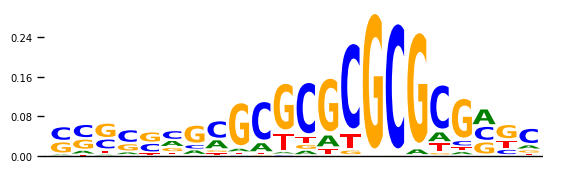

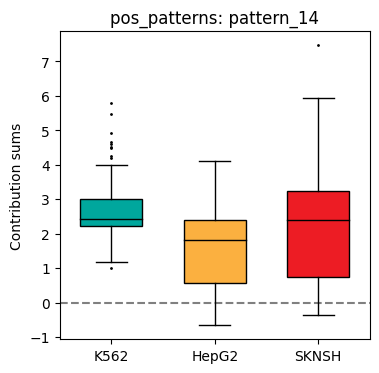


pos_patterns: pattern_15


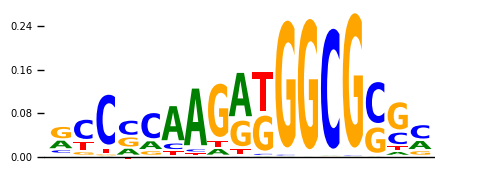

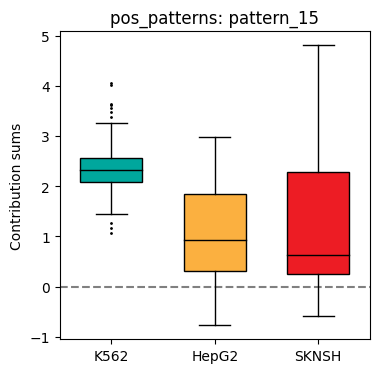


pos_patterns: pattern_16


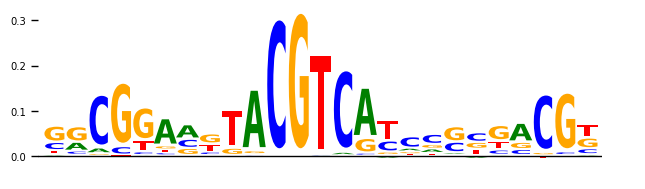

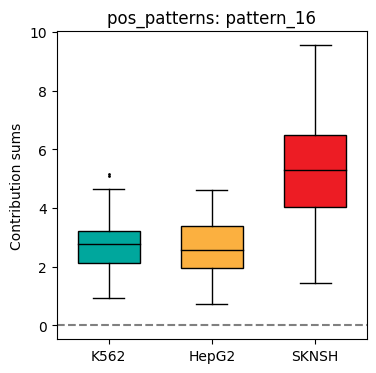


pos_patterns: pattern_17


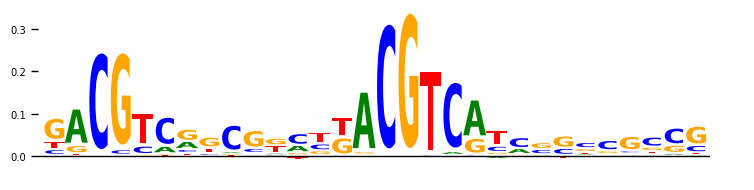

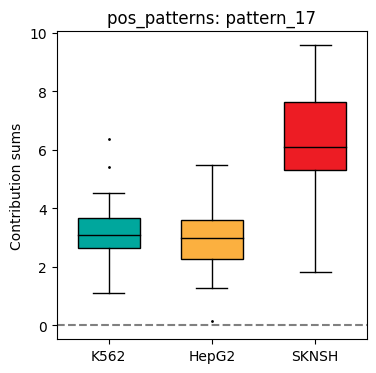


pos_patterns: pattern_18


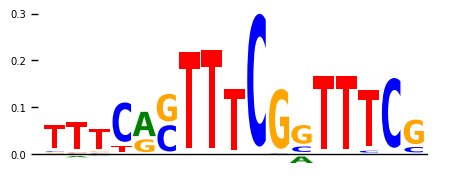

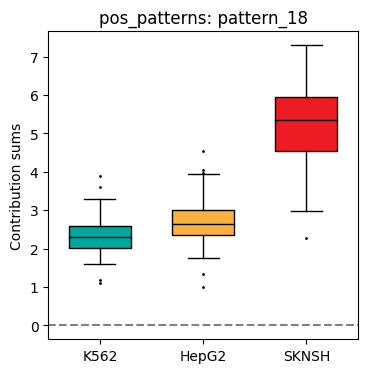


pos_patterns: pattern_19


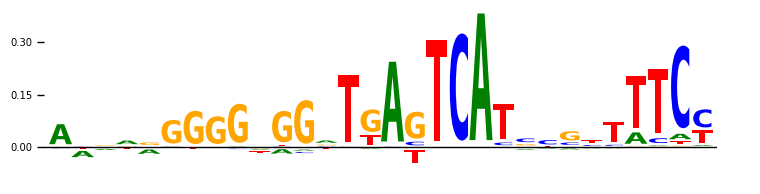

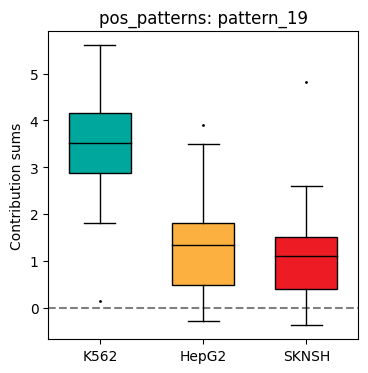


pos_patterns: pattern_2


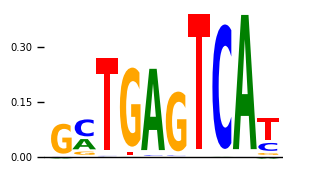

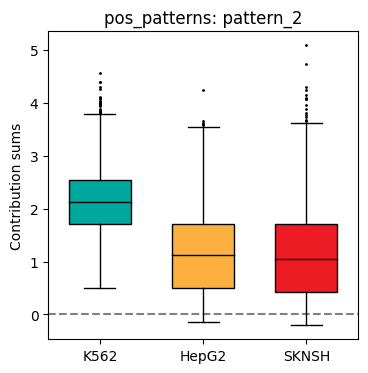


pos_patterns: pattern_20


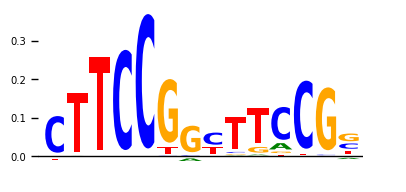

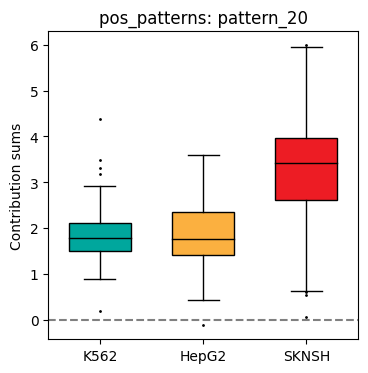


pos_patterns: pattern_21


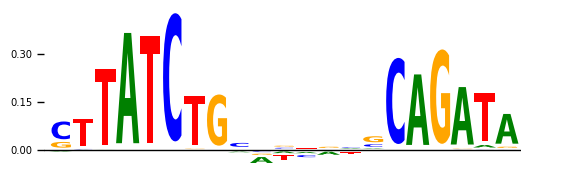

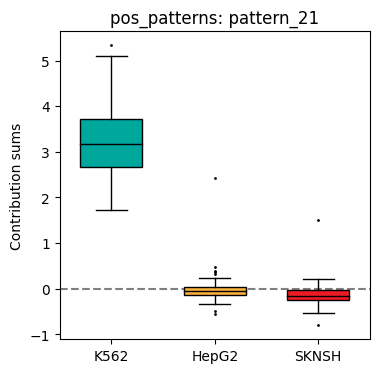


pos_patterns: pattern_22


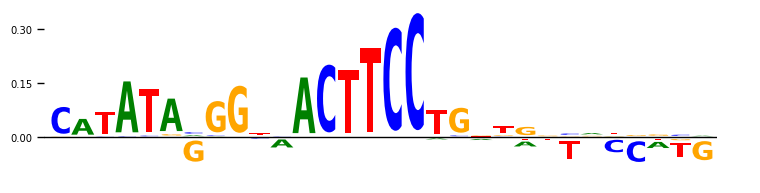

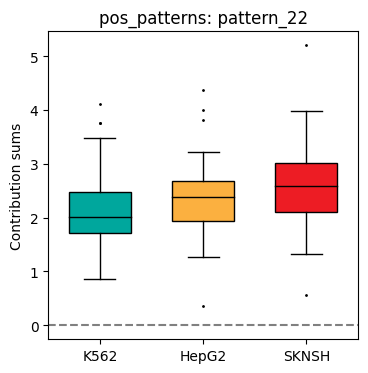


pos_patterns: pattern_23


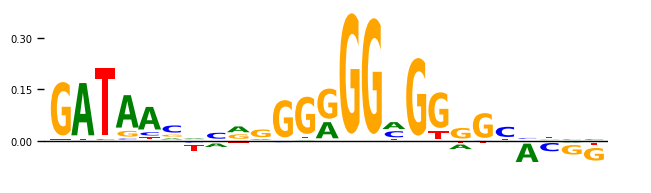

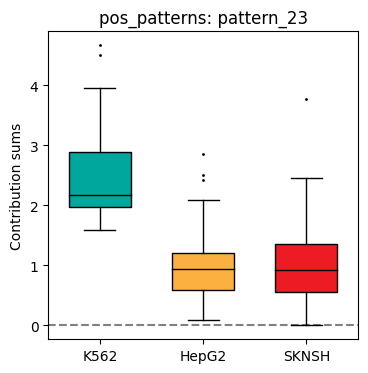


pos_patterns: pattern_24


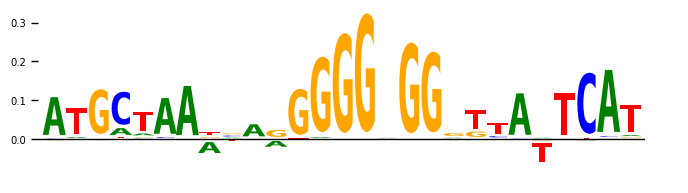

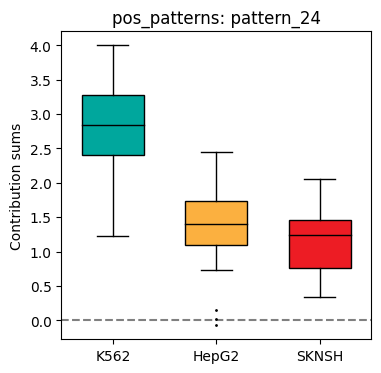


pos_patterns: pattern_25


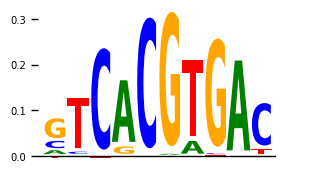

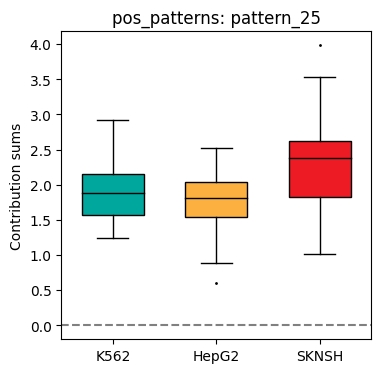


pos_patterns: pattern_26


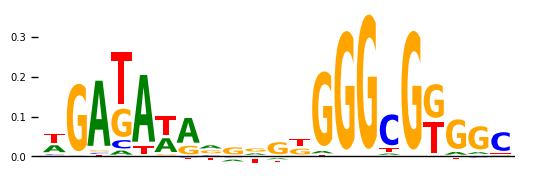

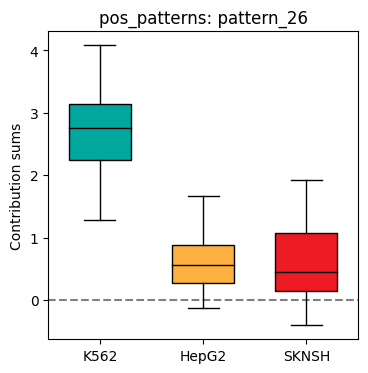


pos_patterns: pattern_27


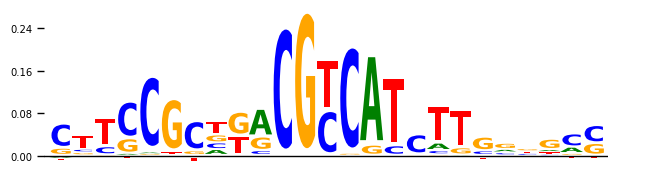

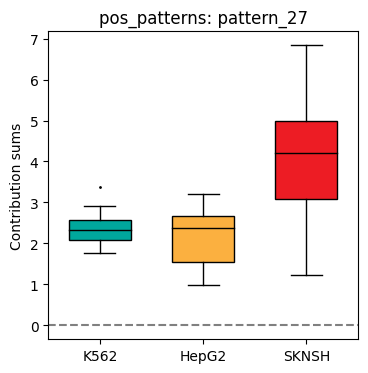


pos_patterns: pattern_3


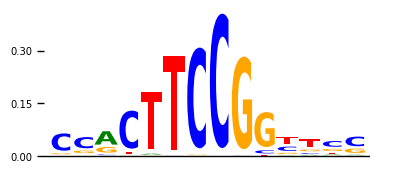

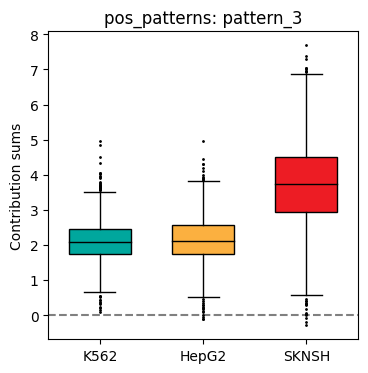


pos_patterns: pattern_4


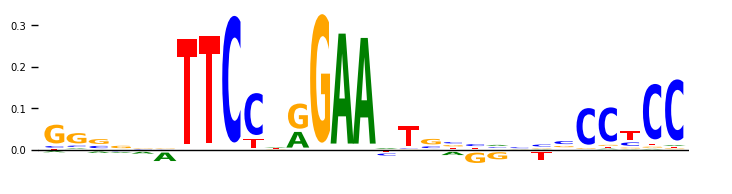

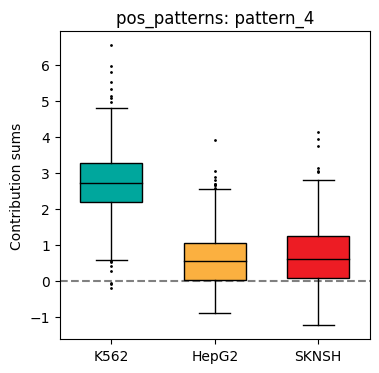


pos_patterns: pattern_5


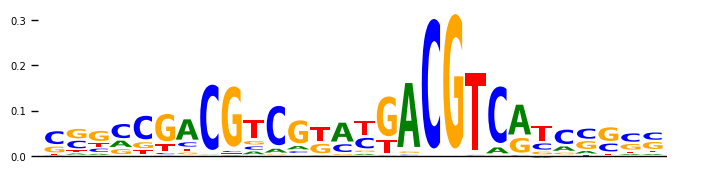

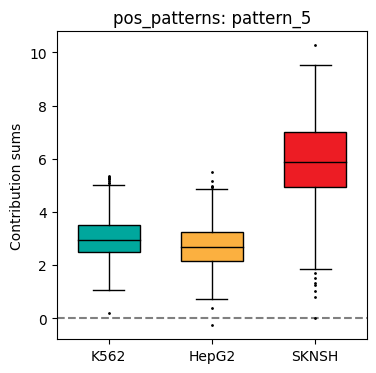


pos_patterns: pattern_6


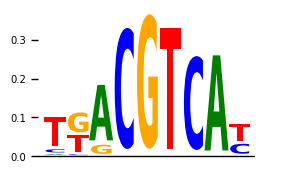

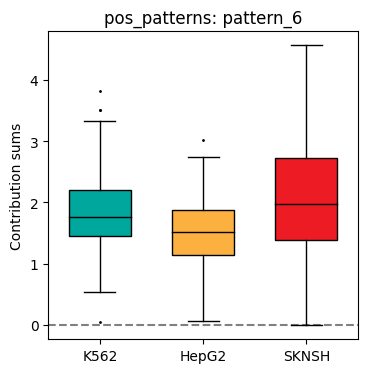


pos_patterns: pattern_7


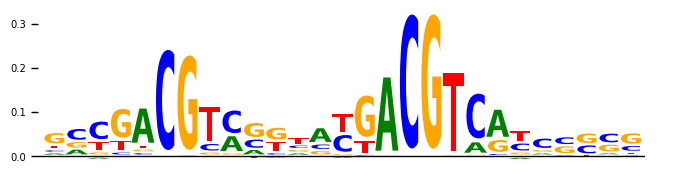

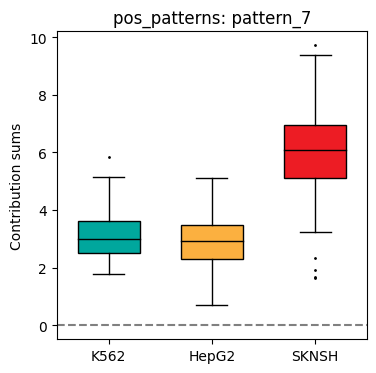


pos_patterns: pattern_8


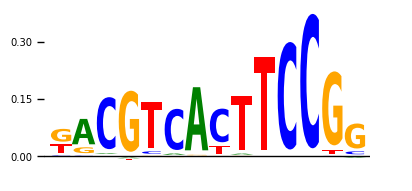

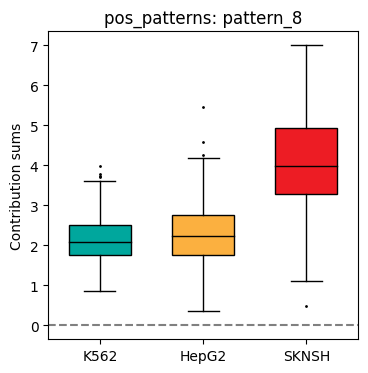


pos_patterns: pattern_9


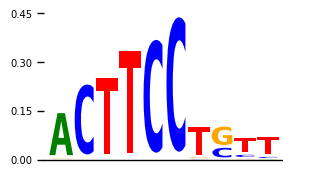

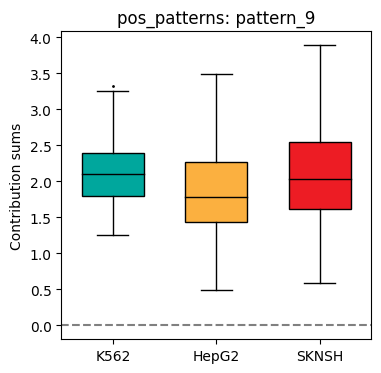



-------------------------- neg_patterns --------------------------
neg_patterns: pattern_0


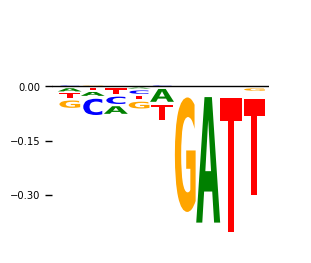

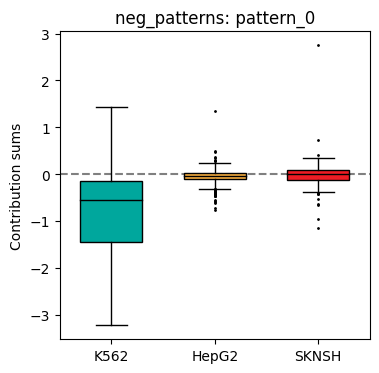


neg_patterns: pattern_1


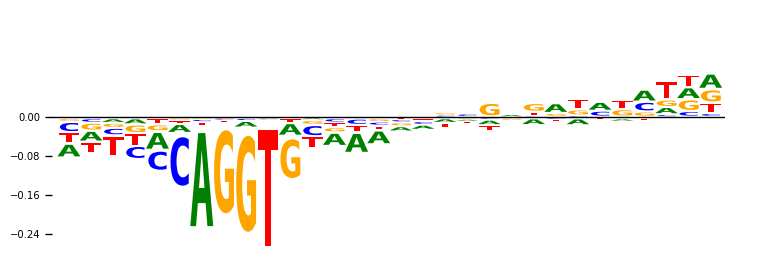

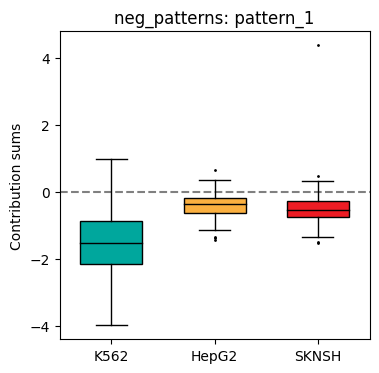


neg_patterns: pattern_2


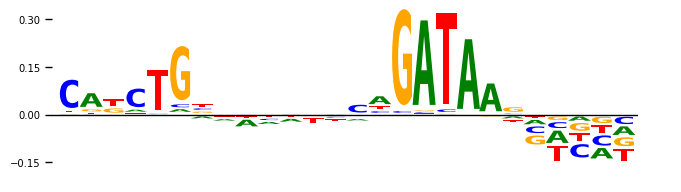

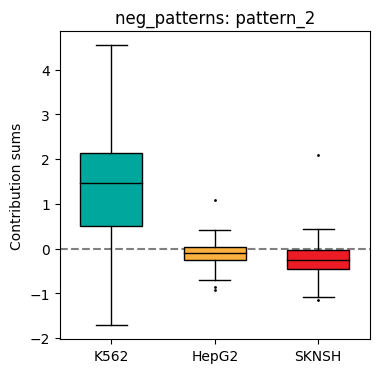


neg_patterns: pattern_3


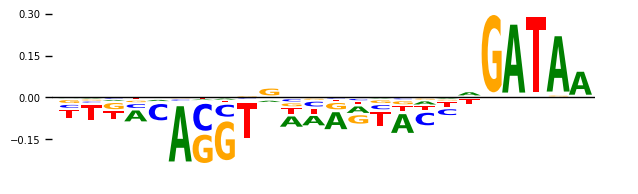

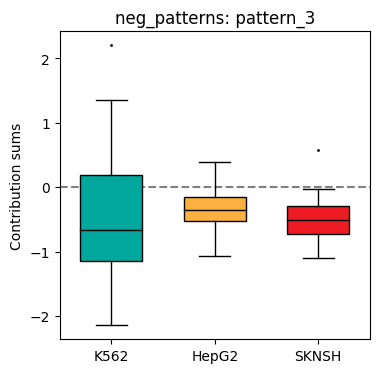


neg_patterns: pattern_4


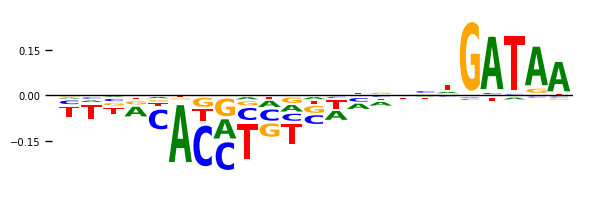

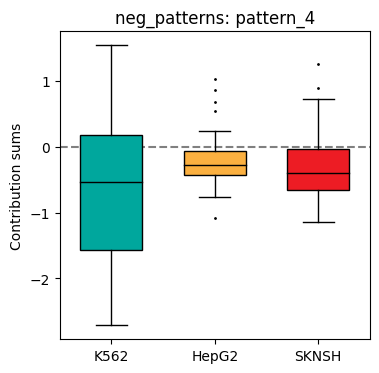

In [ ]:
cell_type = 'K562'
results_file = f"/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_{cell_type}__100k_200.h5"
pattern_group = 'pos_patterns'

results_fh = h5.File(results_file)

score_threshold = 0.05
for pattern_group in ['pos_patterns', 'neg_patterns']:
    print(f'-------------------------- {pattern_group} --------------------------')

    for pattern_name in results_fh[pattern_group].keys():
        seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']

        seq_ids = np.array(seqlets_grp['example_idx'])
        starts = np.array(seqlets_grp['start'])
        ends = np.array(seqlets_grp['end'])
        pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])

        seqlet_group_contributions = all_contributions[:, seq_ids, ...]

        #Trim pattern:
        pattern_scores = np.array(results_fh[pattern_group][pattern_name]['contrib_scores'])
        abs_score_sums = np.abs(pattern_scores.sum(axis=1))

        trim_start = 0
        for i, score_sum in enumerate(abs_score_sums):
            if score_sum > score_threshold:
                trim_start = i
                break

        trim_end = 0
        for i, score_sum in enumerate(reversed(abs_score_sums)):
            if score_sum > score_threshold:
                trim_end = i #len(abs_score_sums) - i
                break

        trimmed_starts = starts + trim_start
        trimmed_ends = ends - trim_end

        trimmed_pattern_scores = pattern_scores[trim_start:len(abs_score_sums) - trim_end, :]

        print(f'{pattern_group}: {pattern_name}')
        #vizsequence.plot_weights(trimmed_pattern_scores)
        plot_tensor = torch.Tensor(trimmed_pattern_scores).T
        y_max = plot_tensor.max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xticks([])
        plt.xlabel('')
        plt.ylabel('')
        for spine in plt.gca().spines.values():
                spine.set_visible(False)
        plt.show()

        all_seqlet_score_sums = []
        for i, (seq_trimmed_start, seq_trimmed_end) in enumerate(zip(trimmed_starts, trimmed_ends)):
            seqlet = seqlet_group_contributions[:, i, :, seq_trimmed_start:seq_trimmed_end]
            all_seqlet_score_sums.append(seqlet.sum(dim=[-2,-1]))
        all_seqlet_score_sums = torch.stack(all_seqlet_score_sums)

        data = all_seqlet_score_sums.numpy()
        plt.figure(figsize=(4, 4))
        plt.axhline(y=0, color='gray', linestyle='--', zorder=0)
        boxplot = plt.boxplot(data, labels=cell_types, patch_artist=True, widths=0.6)

        # Set fill colors for each box
        for box, color in zip(boxplot['boxes'], cell_colors):
            box.set(facecolor=color, alpha=1)

        for median in boxplot['medians']:
            median.set(color='black')

        for flier in boxplot['fliers']:
            flier.set(marker='.', markersize=2, markerfacecolor=flier.get_color())

        plt.title(f'{pattern_group}: {pattern_name}')
        #plt.xlabel('Distributions')
        plt.ylabel('Contribution sums')
        plt.grid(False)
        plt.show()

        print('')
    print('')

results_fh.close()

###HepG2

-------------------------- pos_patterns --------------------------
pos_patterns: pattern_0


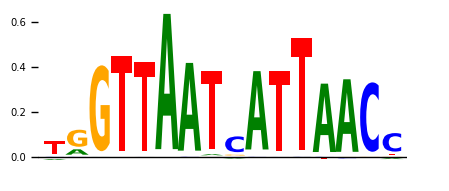

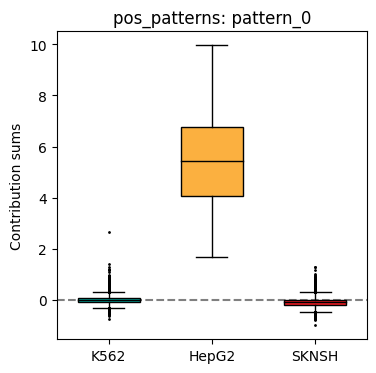


pos_patterns: pattern_1


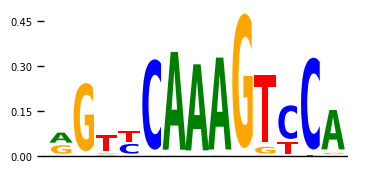

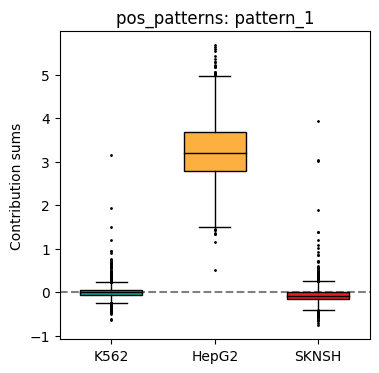


pos_patterns: pattern_10


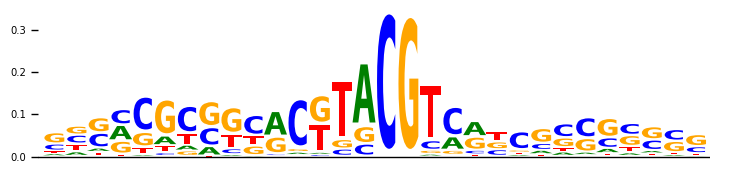

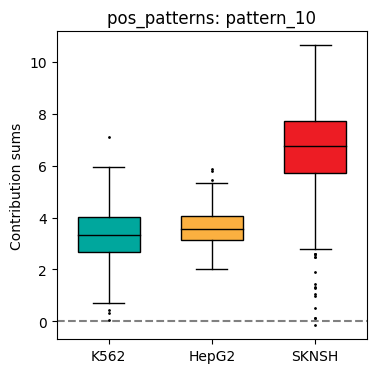


pos_patterns: pattern_11


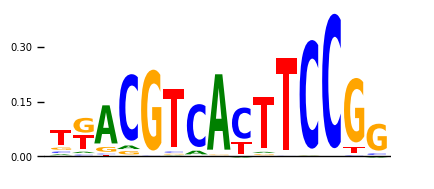

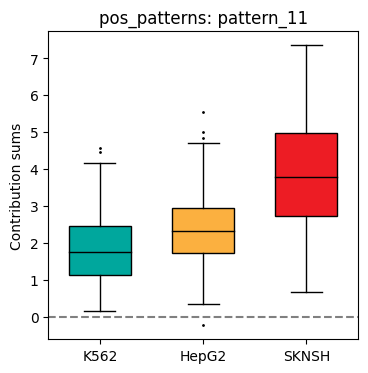


pos_patterns: pattern_12


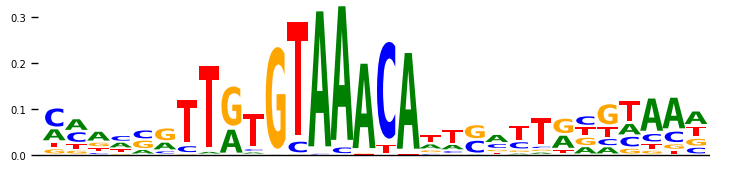

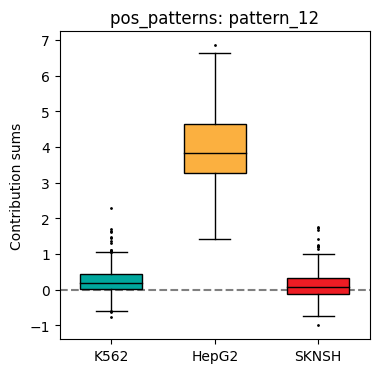


pos_patterns: pattern_13


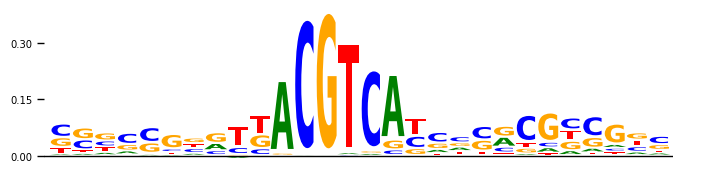

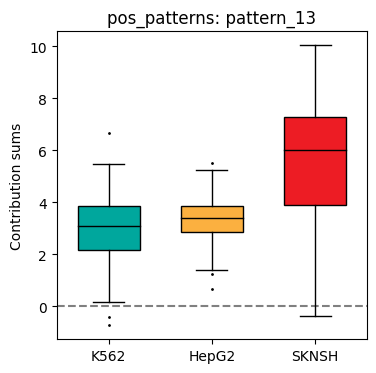


pos_patterns: pattern_14


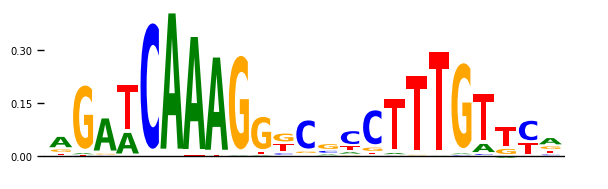

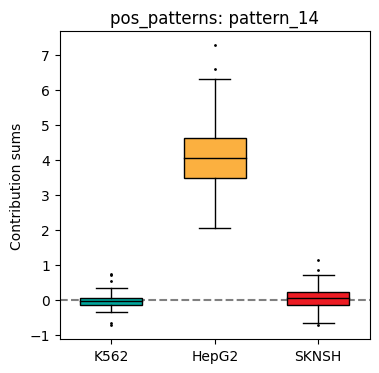


pos_patterns: pattern_15


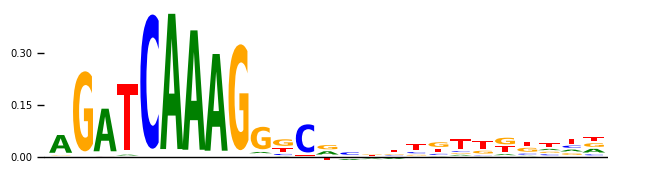

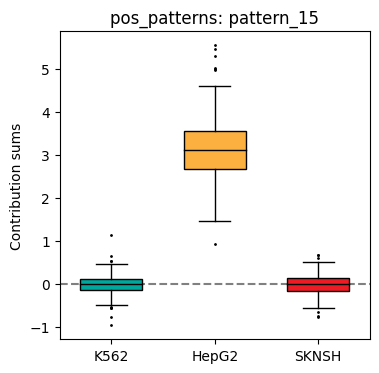


pos_patterns: pattern_16


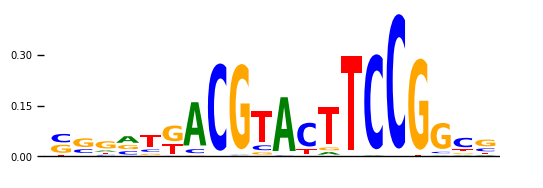

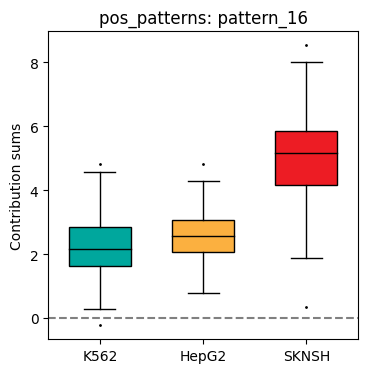


pos_patterns: pattern_17


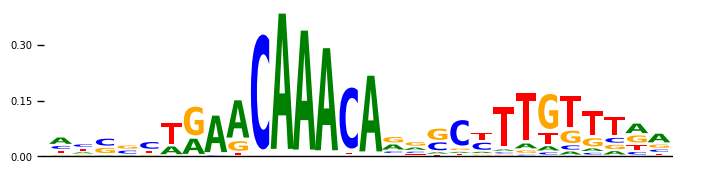

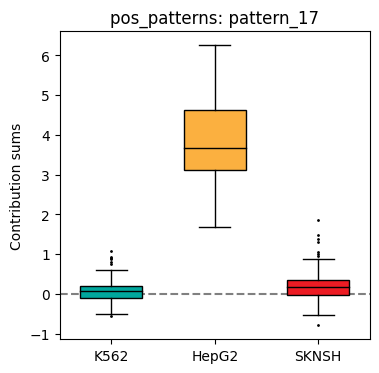


pos_patterns: pattern_18


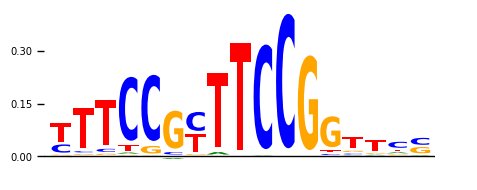

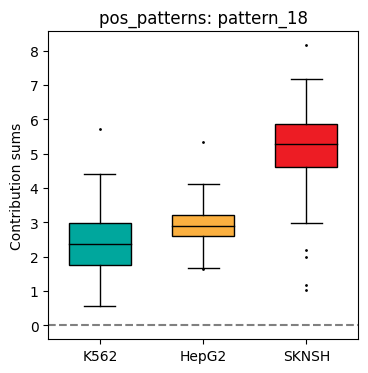


pos_patterns: pattern_19


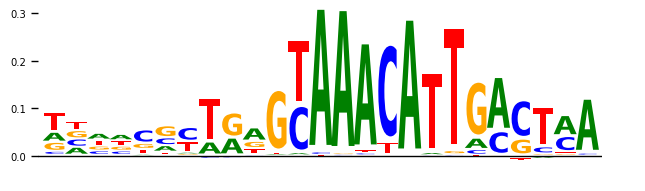

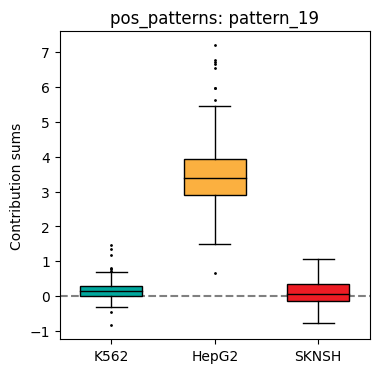


pos_patterns: pattern_2


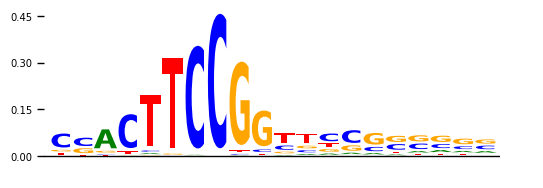

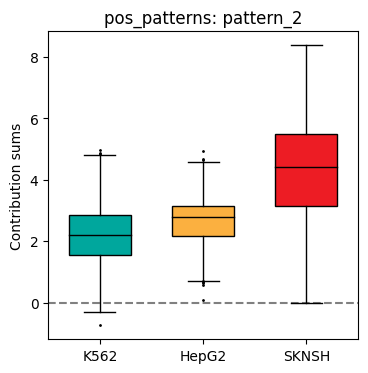


pos_patterns: pattern_20


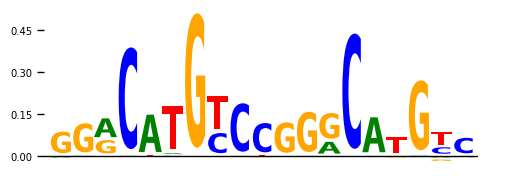

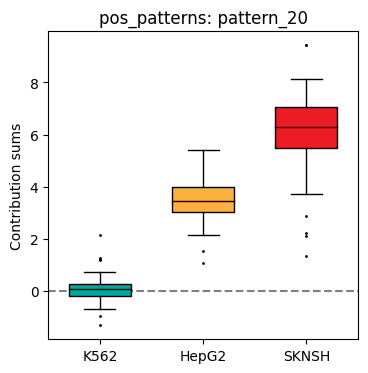


pos_patterns: pattern_21


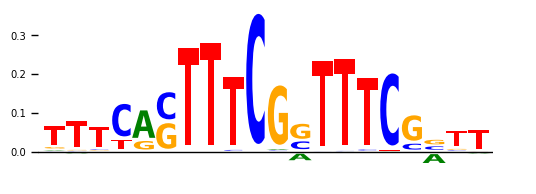

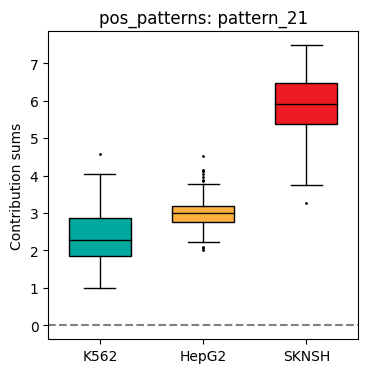


pos_patterns: pattern_22


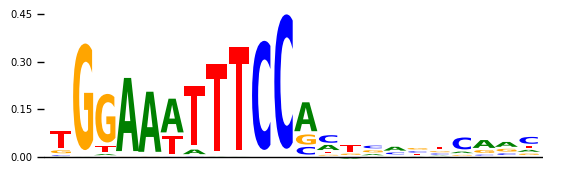

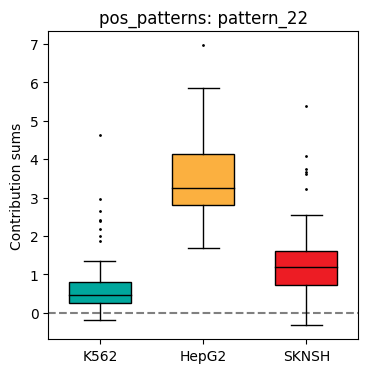


pos_patterns: pattern_23


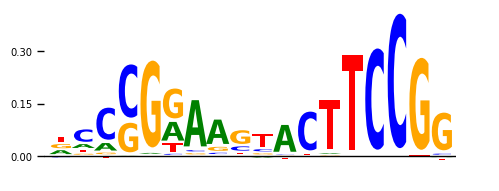

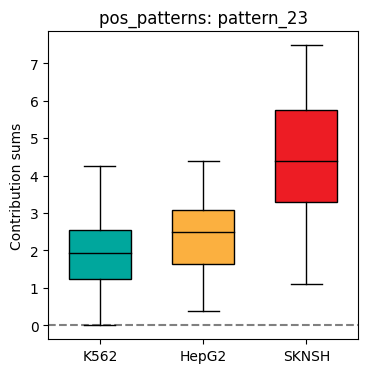


pos_patterns: pattern_24


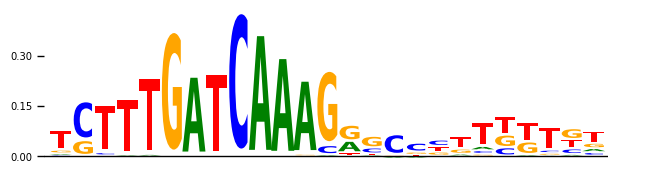

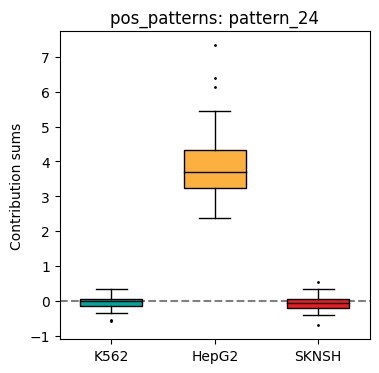


pos_patterns: pattern_25


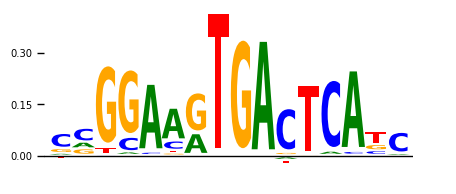

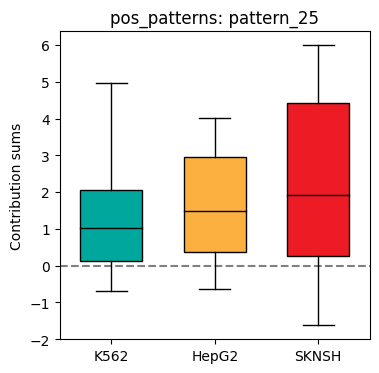


pos_patterns: pattern_3


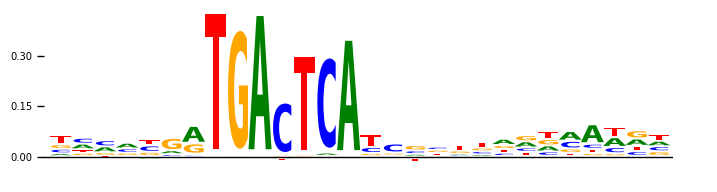

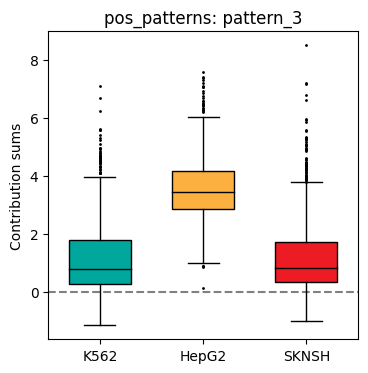


pos_patterns: pattern_4


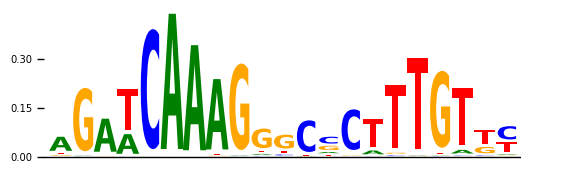

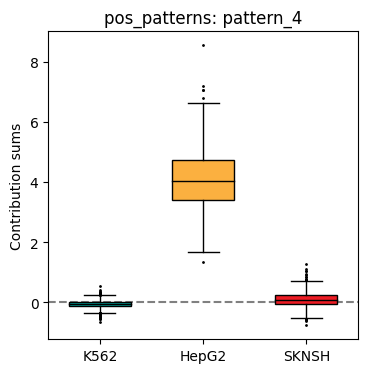


pos_patterns: pattern_5


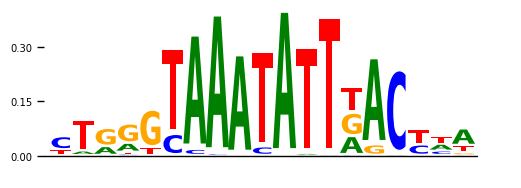

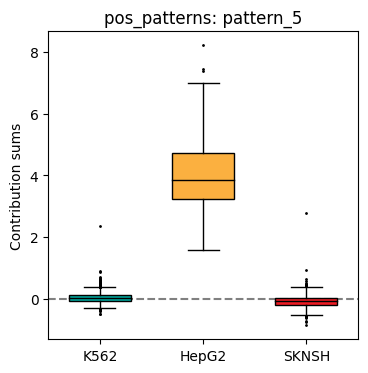


pos_patterns: pattern_6


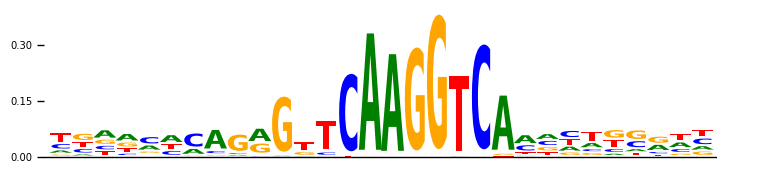

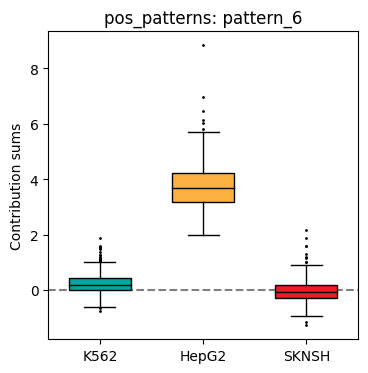


pos_patterns: pattern_7


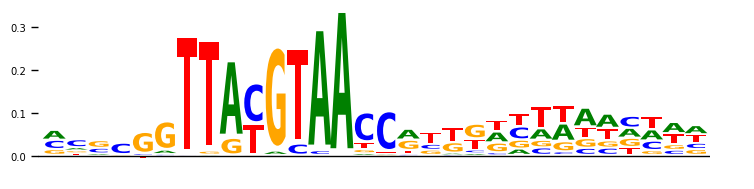

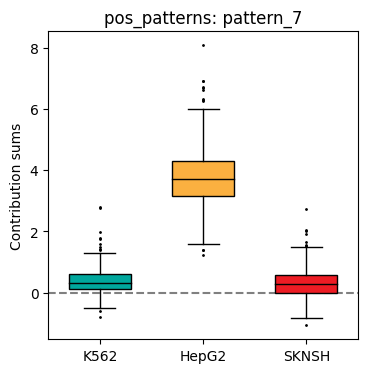


pos_patterns: pattern_8


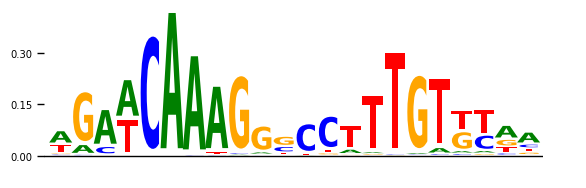

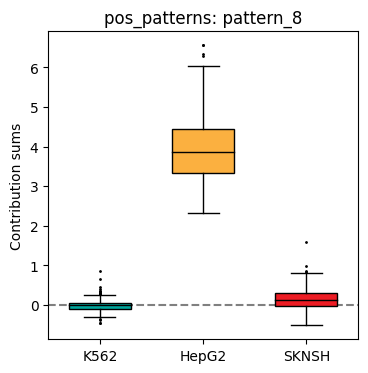


pos_patterns: pattern_9


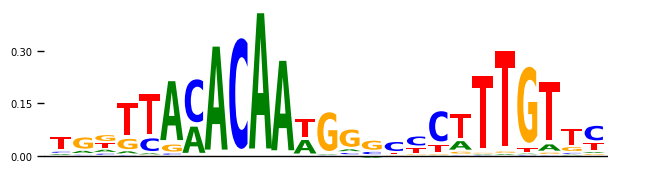

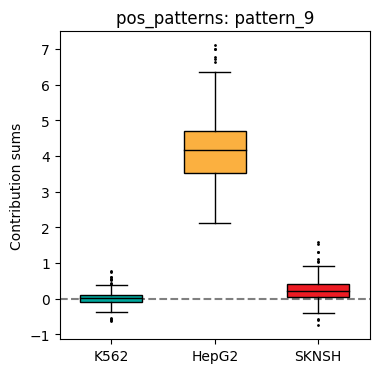



-------------------------- neg_patterns --------------------------
neg_patterns: pattern_0


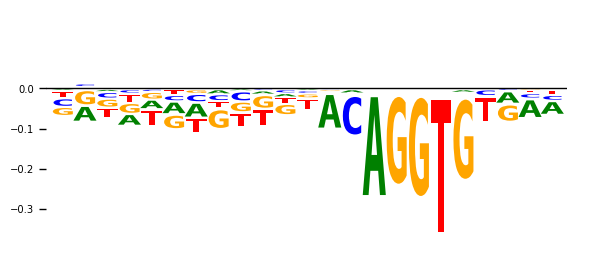

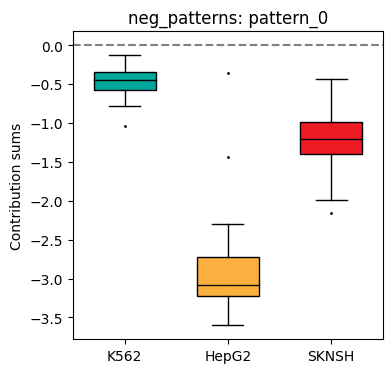


neg_patterns: pattern_1


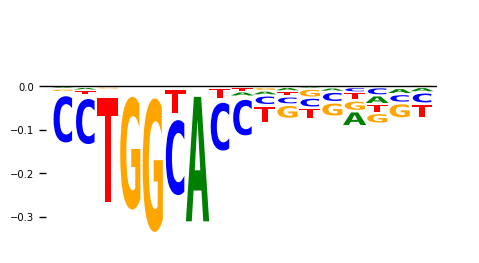

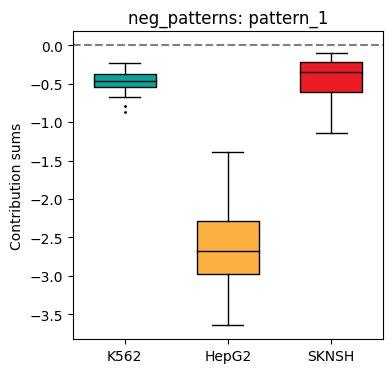

In [ ]:
cell_type = 'HepG2'
results_file = f"/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_{cell_type}__100k_200.h5"
pattern_group = 'pos_patterns'

results_fh = h5.File(results_file)

score_threshold = 0.05
for pattern_group in ['pos_patterns', 'neg_patterns']:
    print(f'-------------------------- {pattern_group} --------------------------')

    for pattern_name in results_fh[pattern_group].keys():
        seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']

        seq_ids = np.array(seqlets_grp['example_idx'])
        starts = np.array(seqlets_grp['start'])
        ends = np.array(seqlets_grp['end'])
        pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])

        seqlet_group_contributions = all_contributions[:, seq_ids, ...]

        #Trim pattern:
        pattern_scores = np.array(results_fh[pattern_group][pattern_name]['contrib_scores'])
        abs_score_sums = np.abs(pattern_scores.sum(axis=1))

        trim_start = 0
        for i, score_sum in enumerate(abs_score_sums):
            if score_sum > score_threshold:
                trim_start = i
                break

        trim_end = 0
        for i, score_sum in enumerate(reversed(abs_score_sums)):
            if score_sum > score_threshold:
                trim_end = i #len(abs_score_sums) - i
                break

        trimmed_starts = starts + trim_start
        trimmed_ends = ends - trim_end

        trimmed_pattern_scores = pattern_scores[trim_start:len(abs_score_sums) - trim_end, :]

        print(f'{pattern_group}: {pattern_name}')
        #vizsequence.plot_weights(trimmed_pattern_scores)
        plot_tensor = torch.Tensor(trimmed_pattern_scores).T
        y_max = plot_tensor.max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xticks([])
        plt.xlabel('')
        plt.ylabel('')
        for spine in plt.gca().spines.values():
                spine.set_visible(False)
        plt.show()

        all_seqlet_score_sums = []
        for i, (seq_trimmed_start, seq_trimmed_end) in enumerate(zip(trimmed_starts, trimmed_ends)):
            seqlet = seqlet_group_contributions[:, i, :, seq_trimmed_start:seq_trimmed_end]
            all_seqlet_score_sums.append(seqlet.sum(dim=[-2,-1]))
        all_seqlet_score_sums = torch.stack(all_seqlet_score_sums)

        data = all_seqlet_score_sums.numpy()
        plt.figure(figsize=(4, 4))
        plt.axhline(y=0, color='gray', linestyle='--', zorder=0)
        boxplot = plt.boxplot(data, labels=cell_types, patch_artist=True, widths=0.6)

        # Set fill colors for each box
        for box, color in zip(boxplot['boxes'], cell_colors):
            box.set(facecolor=color, alpha=1)

        for median in boxplot['medians']:
            median.set(color='black')

        for flier in boxplot['fliers']:
            flier.set(marker='.', markersize=2, markerfacecolor=flier.get_color())

        plt.title(f'{pattern_group}: {pattern_name}')
        #plt.xlabel('Distributions')
        plt.ylabel('Contribution sums')
        plt.grid(False)
        plt.show()

        print('')
    print('')

results_fh.close()

###SKNSH

-------------------------- pos_patterns --------------------------
pos_patterns: pattern_0


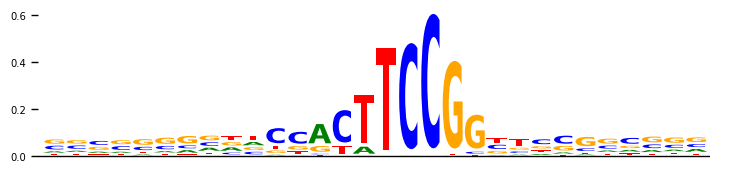

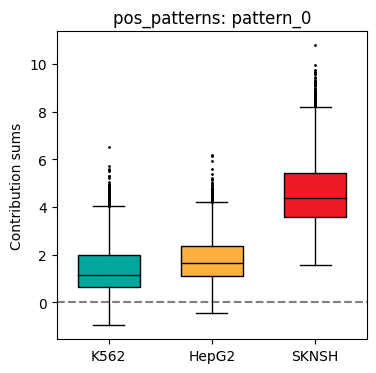


pos_patterns: pattern_1


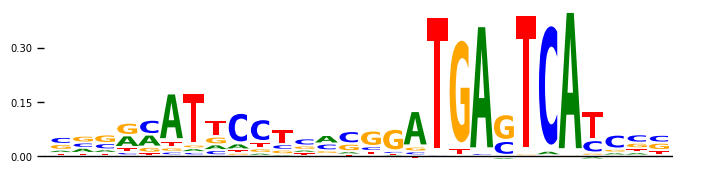

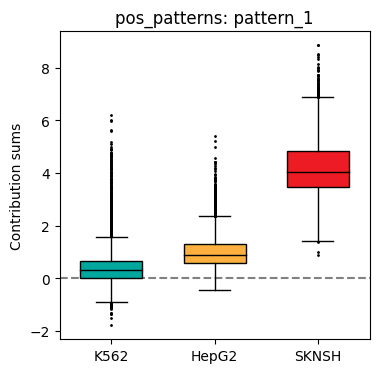


pos_patterns: pattern_10


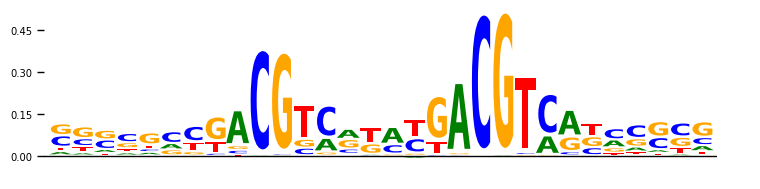

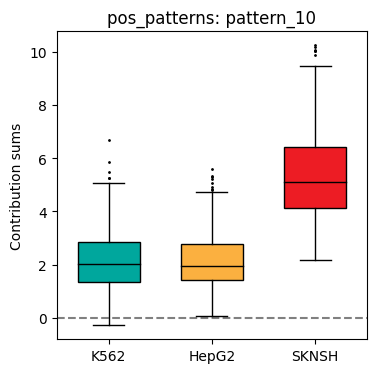


pos_patterns: pattern_11


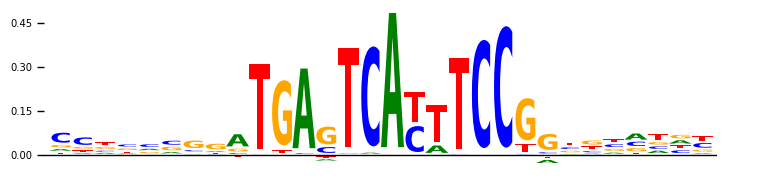

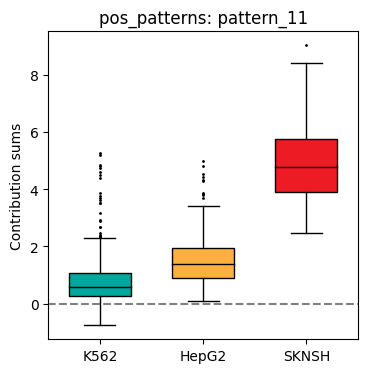


pos_patterns: pattern_12


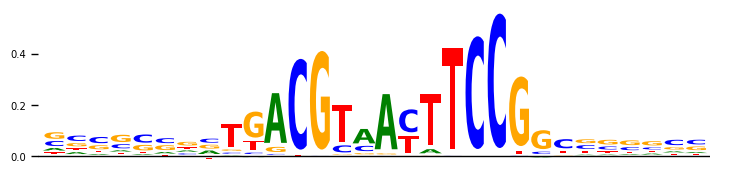

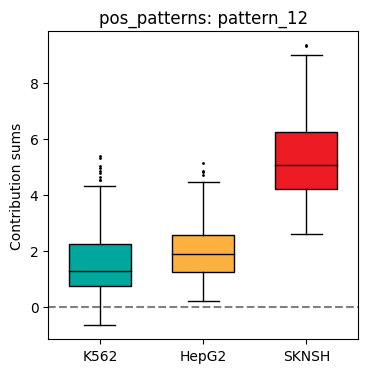


pos_patterns: pattern_13


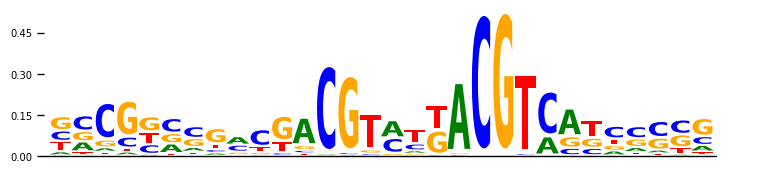

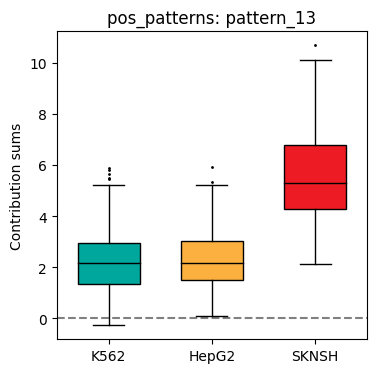


pos_patterns: pattern_14


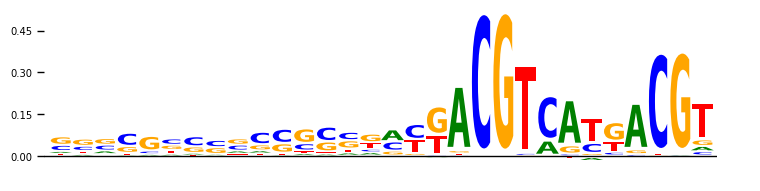

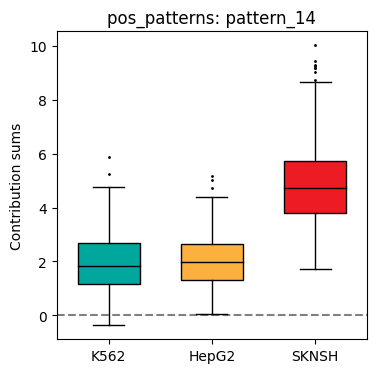


pos_patterns: pattern_15


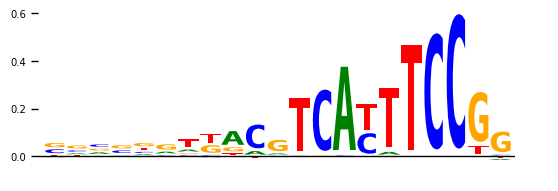

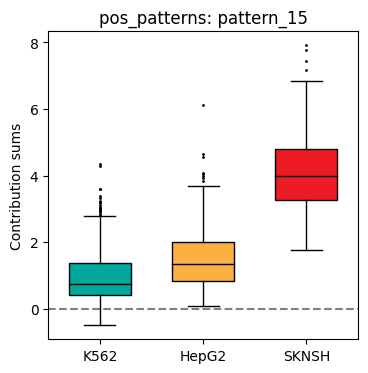


pos_patterns: pattern_16


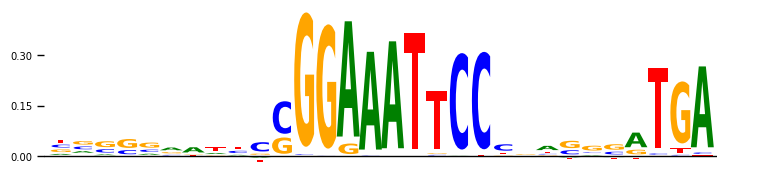

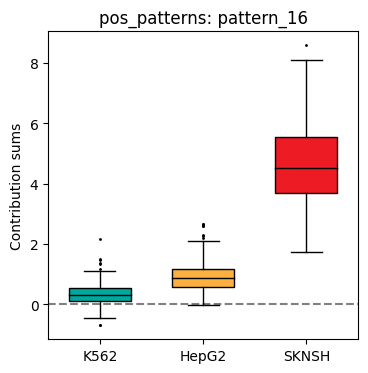


pos_patterns: pattern_17


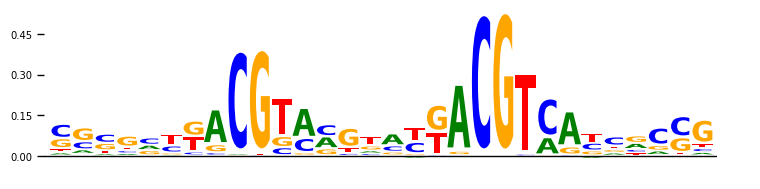

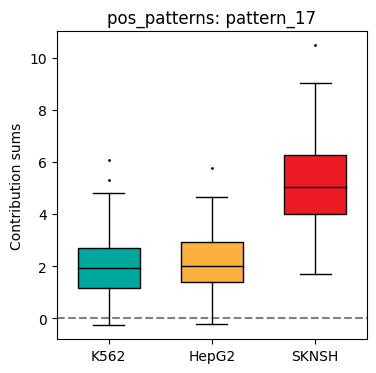


pos_patterns: pattern_18


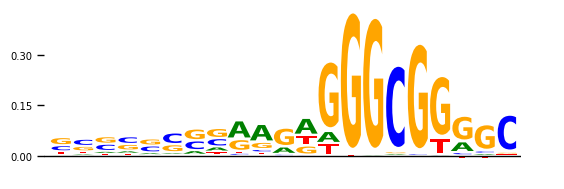

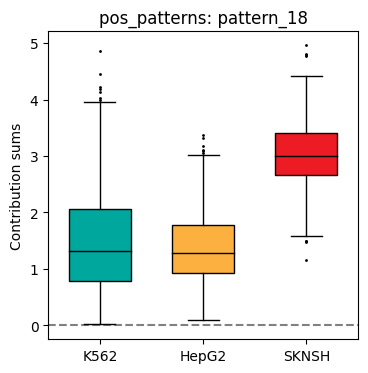


pos_patterns: pattern_19


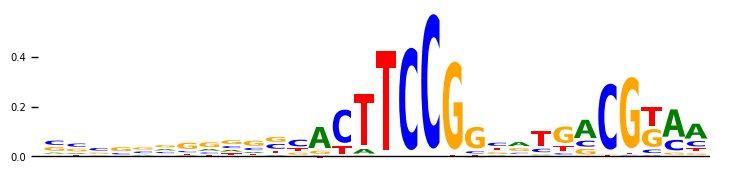

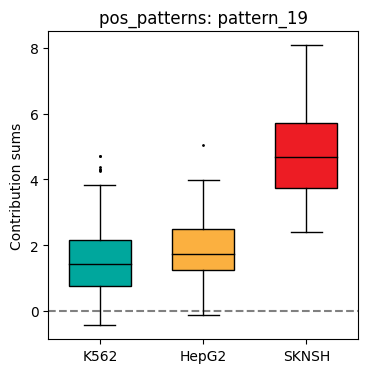


pos_patterns: pattern_2


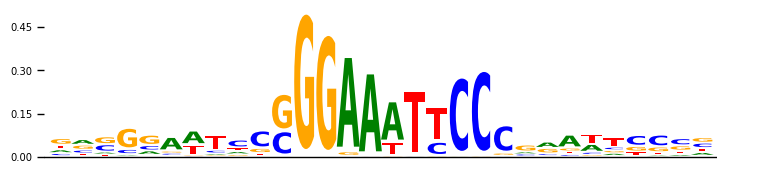

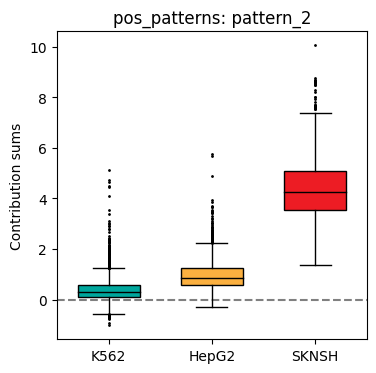


pos_patterns: pattern_20


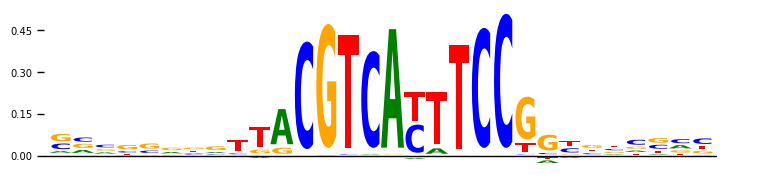

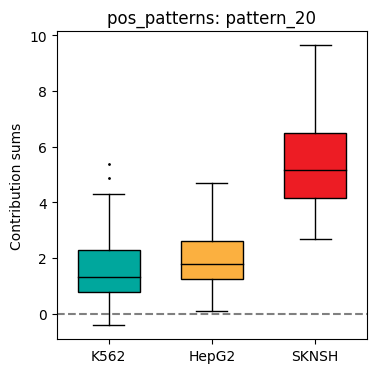


pos_patterns: pattern_21


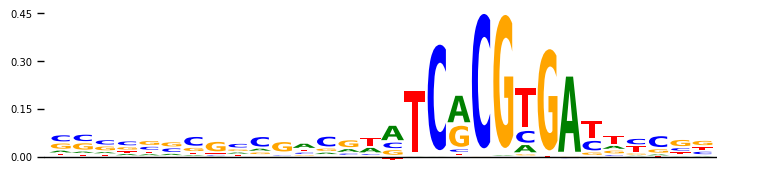

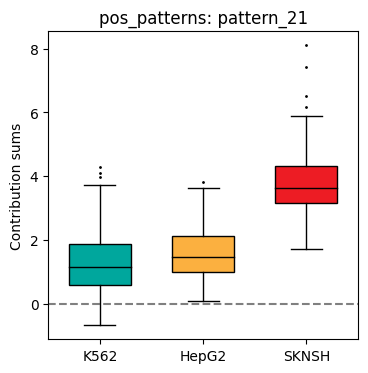


pos_patterns: pattern_22


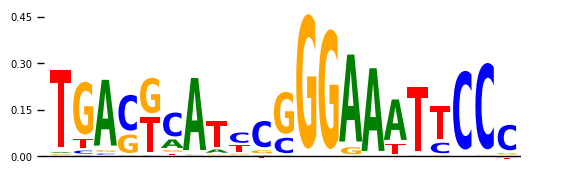

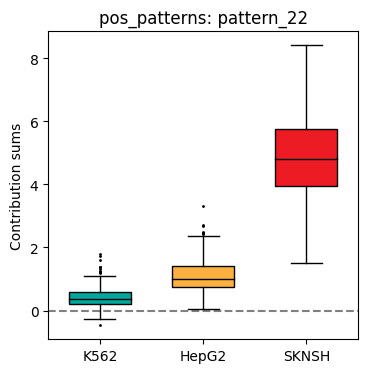


pos_patterns: pattern_23


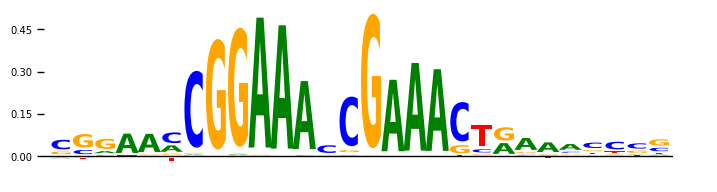

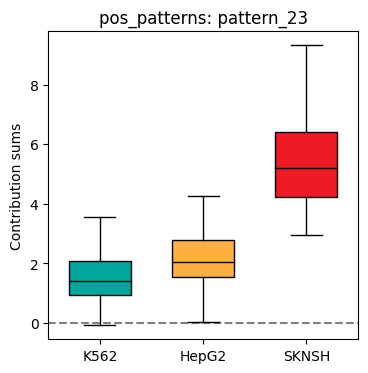


pos_patterns: pattern_24


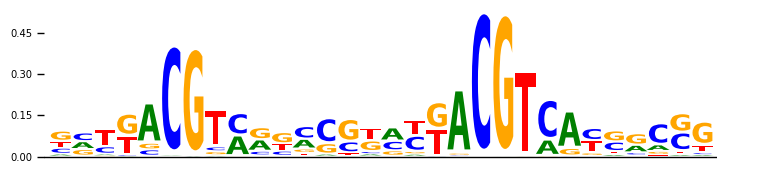

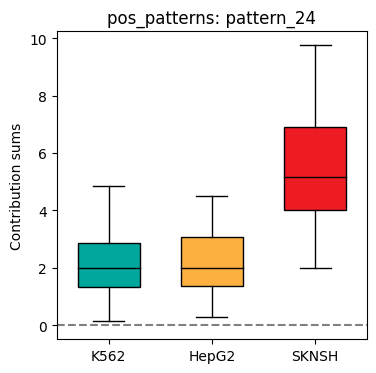


pos_patterns: pattern_25


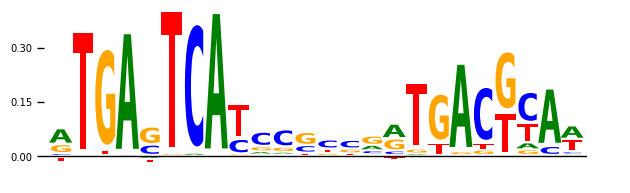

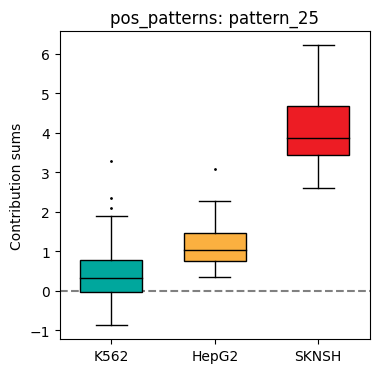


pos_patterns: pattern_26


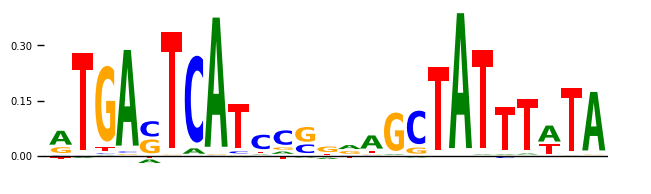

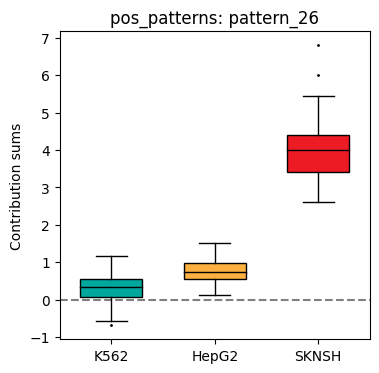


pos_patterns: pattern_27


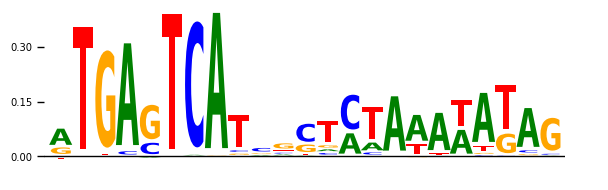

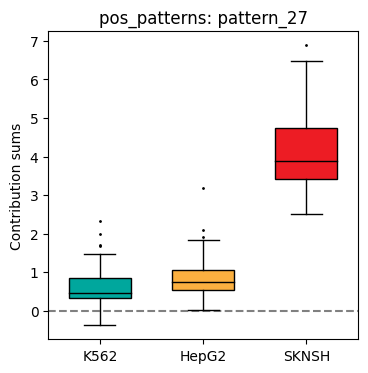


pos_patterns: pattern_28


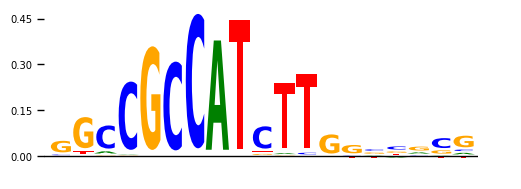

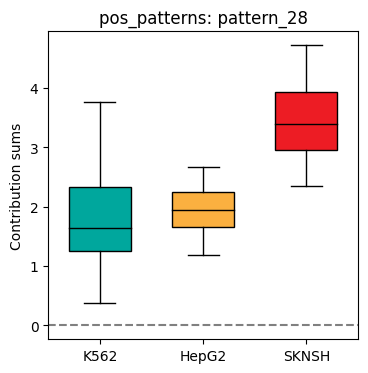


pos_patterns: pattern_29


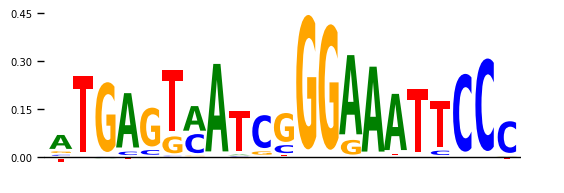

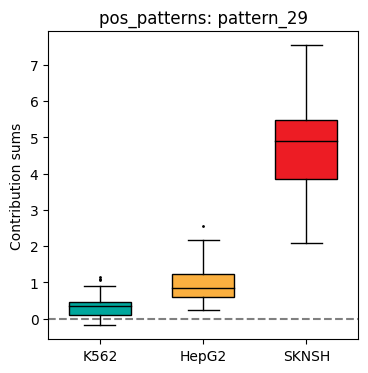


pos_patterns: pattern_3


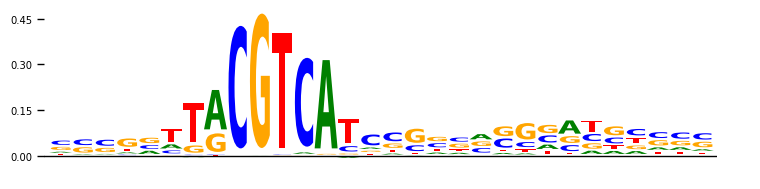

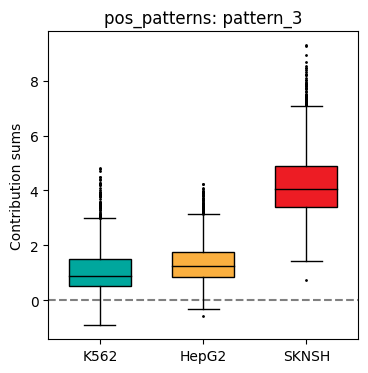


pos_patterns: pattern_30


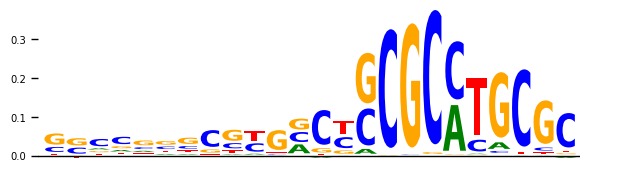

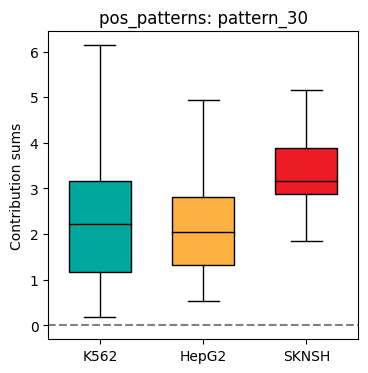


pos_patterns: pattern_31


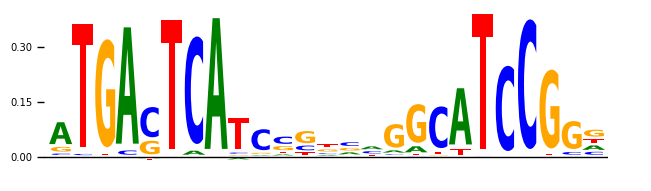

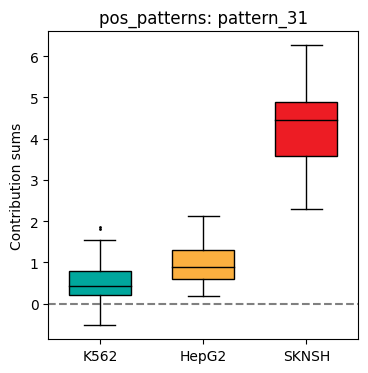


pos_patterns: pattern_32


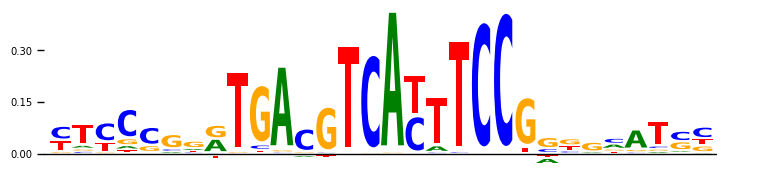

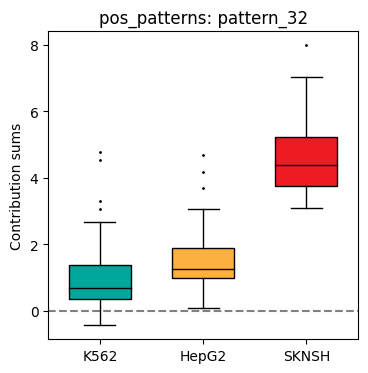


pos_patterns: pattern_33


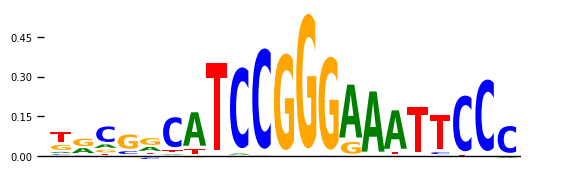

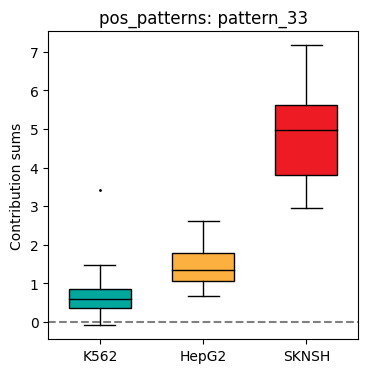


pos_patterns: pattern_34


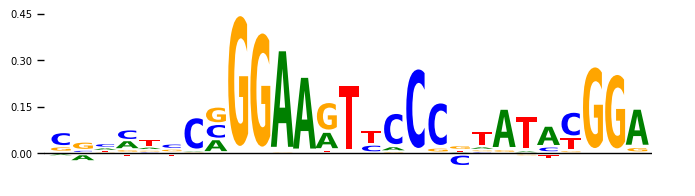

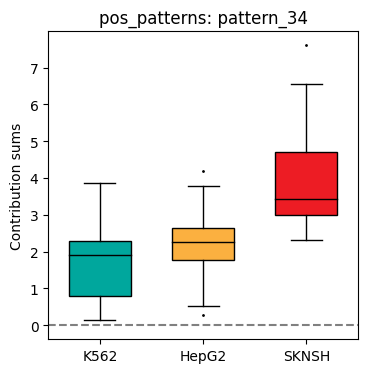


pos_patterns: pattern_35


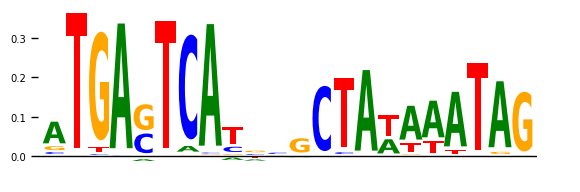

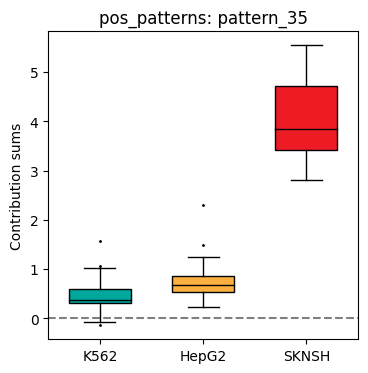


pos_patterns: pattern_36


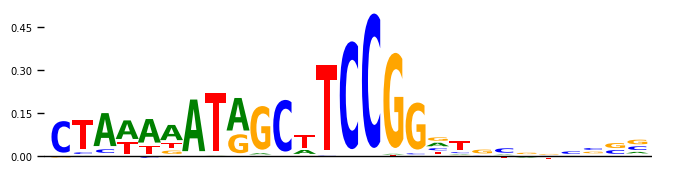

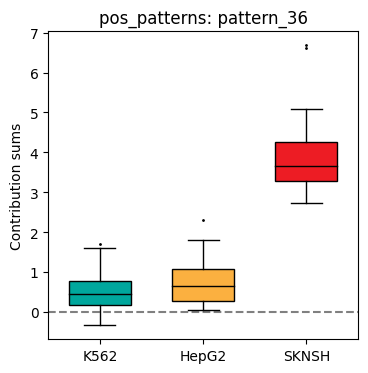


pos_patterns: pattern_37


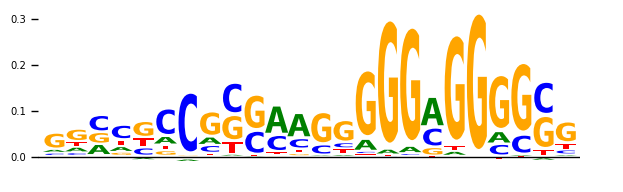

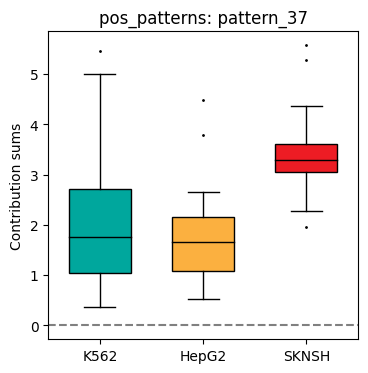


pos_patterns: pattern_38


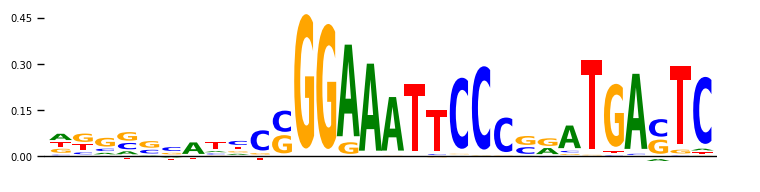

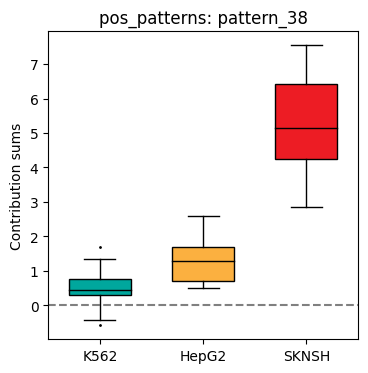


pos_patterns: pattern_39


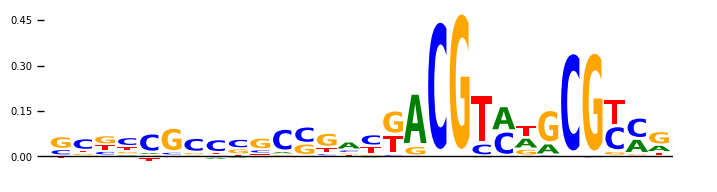

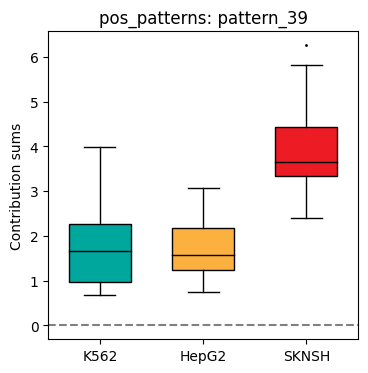


pos_patterns: pattern_4


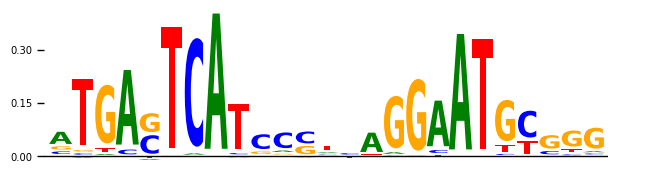

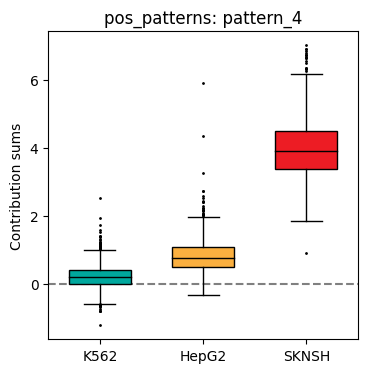


pos_patterns: pattern_40


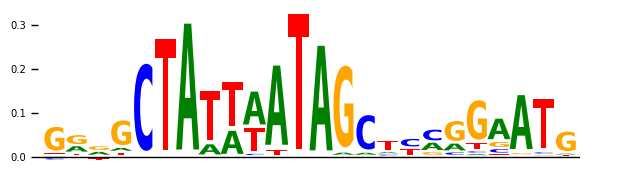

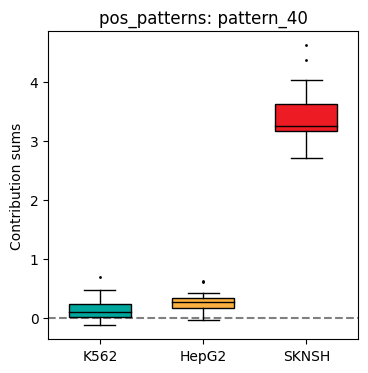


pos_patterns: pattern_5


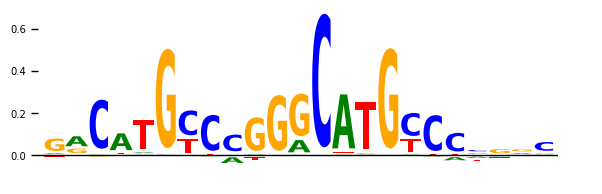

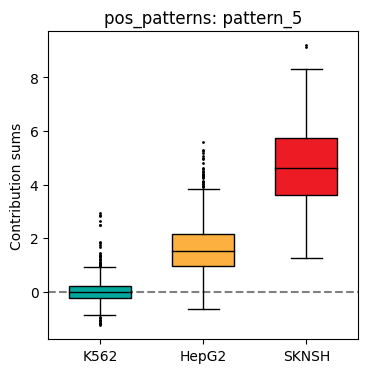


pos_patterns: pattern_6


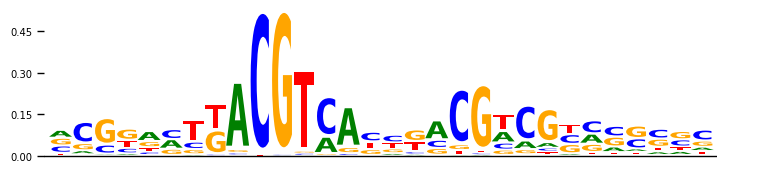

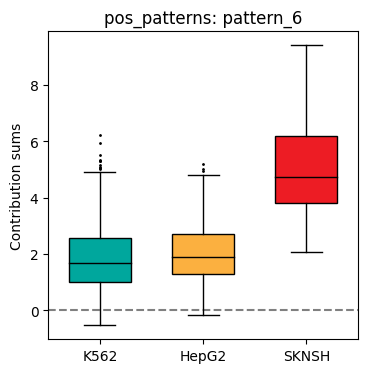


pos_patterns: pattern_7


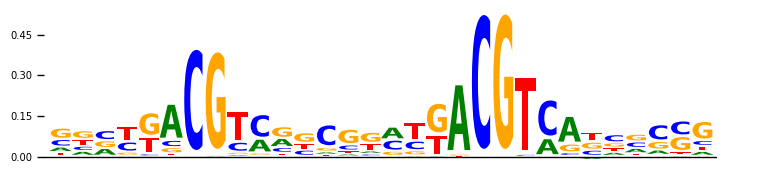

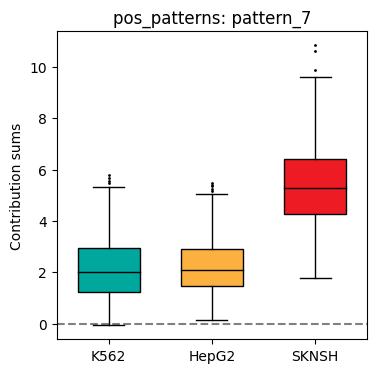


pos_patterns: pattern_8


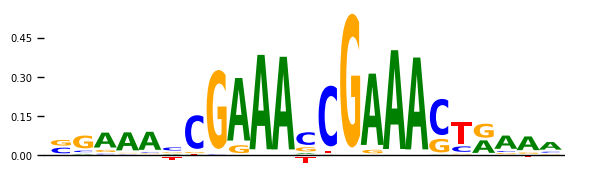

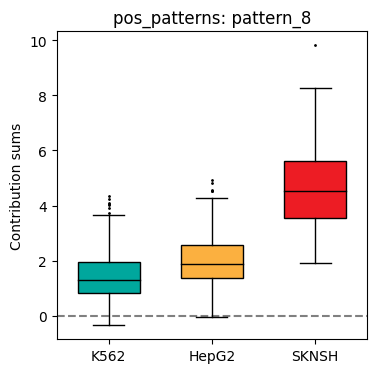


pos_patterns: pattern_9


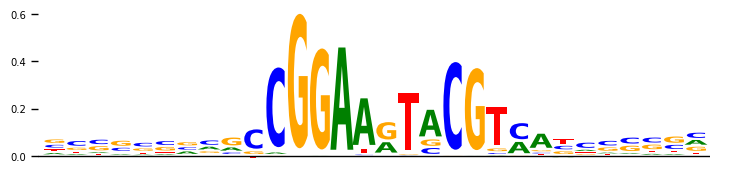

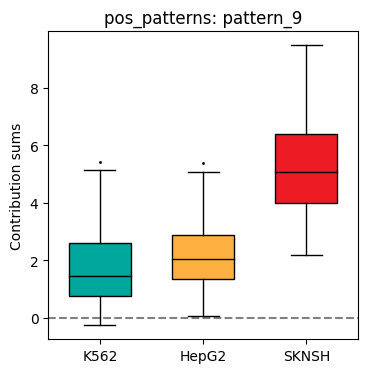

In [ ]:
cell_type = 'SKNSH'
results_file = f"/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_{cell_type}__100k_200.h5"
pattern_group = 'pos_patterns'

results_fh = h5.File(results_file)

score_threshold = 0.05
for pattern_group in ['pos_patterns']: #, 'neg_patterns']:
    print(f'-------------------------- {pattern_group} --------------------------')

    for pattern_name in results_fh[pattern_group].keys():
        seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']

        seq_ids = np.array(seqlets_grp['example_idx'])
        starts = np.array(seqlets_grp['start'])
        ends = np.array(seqlets_grp['end'])
        pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])

        seqlet_group_contributions = all_contributions[:, seq_ids, ...]

        #Trim pattern:
        pattern_scores = np.array(results_fh[pattern_group][pattern_name]['contrib_scores'])
        abs_score_sums = np.abs(pattern_scores.sum(axis=1))

        trim_start = 0
        for i, score_sum in enumerate(abs_score_sums):
            if score_sum > score_threshold:
                trim_start = i
                break

        trim_end = 0
        for i, score_sum in enumerate(reversed(abs_score_sums)):
            if score_sum > score_threshold:
                trim_end = i #len(abs_score_sums) - i
                break

        trimmed_starts = starts + trim_start
        trimmed_ends = ends - trim_end

        trimmed_pattern_scores = pattern_scores[trim_start:len(abs_score_sums) - trim_end, :]

        print(f'{pattern_group}: {pattern_name}')
        #vizsequence.plot_weights(trimmed_pattern_scores)
        plot_tensor = torch.Tensor(trimmed_pattern_scores).T
        y_max = plot_tensor.max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xticks([])
        plt.xlabel('')
        plt.ylabel('')
        for spine in plt.gca().spines.values():
                spine.set_visible(False)
        plt.show()

        all_seqlet_score_sums = []
        for i, (seq_trimmed_start, seq_trimmed_end) in enumerate(zip(trimmed_starts, trimmed_ends)):
            seqlet = seqlet_group_contributions[:, i, :, seq_trimmed_start:seq_trimmed_end]
            all_seqlet_score_sums.append(seqlet.sum(dim=[-2,-1]))
        all_seqlet_score_sums = torch.stack(all_seqlet_score_sums)

        data = all_seqlet_score_sums.numpy()
        plt.figure(figsize=(4, 4))
        plt.axhline(y=0, color='gray', linestyle='--', zorder=0)
        boxplot = plt.boxplot(data, labels=cell_types, patch_artist=True, widths=0.6)

        # Set fill colors for each box
        for box, color in zip(boxplot['boxes'], cell_colors):
            box.set(facecolor=color, alpha=1)

        for median in boxplot['medians']:
            median.set(color='black')

        for flier in boxplot['fliers']:
            flier.set(marker='.', markersize=2, markerfacecolor=flier.get_color())

        plt.title(f'{pattern_group}: {pattern_name}')
        #plt.xlabel('Distributions')
        plt.ylabel('Contribution sums')
        plt.grid(False)
        plt.show()

        print('')
    print('')

results_fh.close()

##Merge results

In [ ]:
np.savez('ohe.npz', onehots_dict['onehots'].numpy())
np.savez('hypscores_K562.npz', contributions_dicts['K562']['hyp_contributions'].numpy())
np.savez('hypscores_HepG2.npz', contributions_dicts['HepG2']['hyp_contributions'].numpy())
np.savez('hypscores_SKNSH.npz', contributions_dicts['SKNSH']['hyp_contributions'].numpy())

In [ ]:
%%time

%matplotlib inline
from modiscolite.aggregator import SimilarPatternsCollapser
from modiscolite.core import TrackSet, Seqlet, SeqletSet

pattern_group = 'pos_patterns' #pos_patterns or neg_patterns

#provide the list of modisco_results files to be merged, along with their
# corresponding one-hot encodings and hypothetical importance scores.
merge_list = [
    ("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_K562__100k_200.h5", "ohe.npz", "hypscores_K562.npz"),
    ("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_HepG2__100k_200.h5", "ohe.npz", "hypscores_HepG2.npz"),
    ("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_SKNSH__100k_200.h5", "ohe.npz", "hypscores_SKNSH.npz")
]

#hyperparameters for merging - these are set
# to the defaults in tfmodisco-lite
min_overlap = 0.7
prob_and_pertrack_sim_merge_thresholds = [(0.8,0.8), (0.5, 0.85), (0.2, 0.9)]
prob_and_pertrack_sim_dealbreaker_thresholds = [(0.4, 0.75), (0.2,0.8), (0.1, 0.85), (0.0,0.9)]
min_frac = 0.2 # also called frac_support_to_trim_to
min_num = 30 # also called min_num_to_trim_to
flank_to_add = 5 # also called initial_flank_to_add
window_size = 20 # also called trim_to_window_size
max_seqlets_subsample = 300 # also called merging_max_seqlets_subsample

union_onehot = []
union_hypscores = []
union_patterncoords = []

exampleidx_offset = 0 #incremented after each modisco results file
for (results_file, onehot_file, hypscores_file) in merge_list:

  print("On file "+results_file)

  results_fh = h5.File(results_file)
  onehot = (np.load(onehot_file)["arr_0"]).transpose(0,2,1)
  hypscores = (np.load(hypscores_file)["arr_0"]).transpose(0,2,1)

  allpattern_exampleidxs = []
  #first, iterate through the patterns and get all the example indices
  # (Note: "example_idx" refers to the index of the sequence that contained
  #  the seqlet)
  for pattern_name in results_fh[pattern_group].keys():
    seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']
    allpattern_exampleidxs.extend(np.array(seqlets_grp['example_idx']))

  #figure out the subset of indices that actually have seqlets, sort it.
  surviving_indices = sorted(list(set(allpattern_exampleidxs)))
  print(str(len(surviving_indices))+" indices had seqlets out of "
        +str(len(onehot)))
  #add the scores for the subset of sequences that have scores to the
  # 'union' list.
  for idx in surviving_indices:
    union_onehot.append(onehot[idx])
    union_hypscores.append(hypscores[idx])

  #create an index remapping based on the subset of surviving indices
  # (we will add exampleidx_offset later)
  idx_remapping = dict(zip(surviving_indices,
                           np.arange(len(surviving_indices))))

  #Now iterate through the patterns again and prep the seqlet coordinates,
  # remapping the example indices as needed.
  #We also add in exampleidx_offset to account for all the previous seqeuences
  # that have already been added to the 'union' lists
  for pattern_name in results_fh[pattern_group].keys():
    seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']
    pattern_exampleidxs = np.array(seqlets_grp['example_idx'])
    #remap the example idxs
    pattern_remapped_exampleidxs = np.array([
        (exampleidx_offset+idx_remapping[idx]) for idx in pattern_exampleidxs])
    pattern_start = np.array(seqlets_grp['start'])
    pattern_end = np.array(seqlets_grp['end'])
    pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])
    union_patterncoords.append((pattern_remapped_exampleidxs,
                                pattern_start, pattern_end, pattern_isrevcomp))
  #increment exampleidx_offset
  exampleidx_offset = (exampleidx_offset + len(surviving_indices))
  results_fh.close()

#create the trackset object
union_onehot = np.array(union_onehot)
union_hypscores = np.array(union_hypscores)
track_set = TrackSet(one_hot=union_onehot,
                     contrib_scores=union_onehot*union_hypscores,
                     hypothetical_contribs=union_hypscores)

#Create pattern objects using the new track_set and modified coordinates
# print("Patterns to be merged:")
all_patterns = []
for (example_idxs, starts, ends, isrevcomps) in union_patterncoords:
  #tfmlite reuses the same object for representing seqlet
  # coordinates as well as seqlets
  seqlet_coords = [Seqlet(example_idx, start, end, isrevcomp) for
                   (example_idx, start, end, isrevcomp) in zip(
                   example_idxs, starts, ends, isrevcomps)]
  seqlets = track_set.create_seqlets(seqlet_coords)
  pattern = SeqletSet(seqlets) #SeqletSet in tfm lite = AggregatedSeqlet in tfm
  all_patterns.append(pattern)
#   print("numseqlets:",len(pattern.seqlets))
#   vizsequence.plot_weights(pattern.contrib_scores)

#bg_freq is used for identifying the region within a merged motif of
# highest information content and then expanding around that region.
bg_freq = np.mean(union_onehot, axis=(0, 1))

#Do the merging
merged_patterns, pattern_merge_hierarchy = SimilarPatternsCollapser(
    patterns=all_patterns,
    track_set=track_set,
    min_overlap=min_overlap,
    prob_and_pertrack_sim_merge_thresholds=prob_and_pertrack_sim_merge_thresholds,
	  prob_and_pertrack_sim_dealbreaker_thresholds=prob_and_pertrack_sim_dealbreaker_thresholds,
	  min_frac=min_frac,
    min_num=min_num,
    flank_to_add=flank_to_add,
    window_size=window_size,
    bg_freq=bg_freq,
	  max_seqlets_subsample=max_seqlets_subsample)

merged_pattern_scores = np.stack([pattern.contrib_scores for pattern in merged_patterns])
merged_pattern_hypscores = np.stack([pattern.hypothetical_contribs for pattern in merged_patterns])
example_idxs = [[x.example_idx for x in pattern.seqlets] for pattern in merged_patterns]
starts = [[x.start for x in pattern.seqlets] for pattern in merged_patterns]
ends = [[x.end for x in pattern.seqlets] for pattern in merged_patterns]
isrevcomps = [[x.is_revcomp for x in pattern.seqlets] for pattern in merged_patterns]

merged_patterns_dict = {'merged_pattern_scores': merged_pattern_scores,
                        'merged_pattern_hypscores': merged_pattern_hypscores,
                        'example_idxs': example_idxs,
                        'starts': starts,
                        'ends': ends,
                        'isrevcomps': isrevcomps
                            }
torch.save(merged_patterns_dict, f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_{pattern_group}.pt')

print("Merged patterns:")

for pattern in merged_patterns:
  print("numseqlets:",len(pattern.seqlets))
  vizsequence.plot_weights(pattern.contrib_scores)

Output hidden; open in https://colab.research.google.com to view.

On file /content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_K562__100k_200.h5
473 indices had seqlets out of 75000
On file /content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_HepG2__100k_200.h5
51 indices had seqlets out of 75000
Merged patterns:
numseqlets: 230


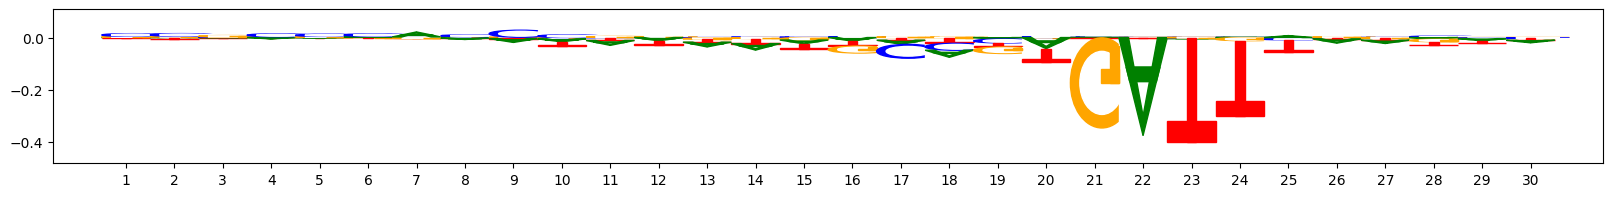

numseqlets: 96


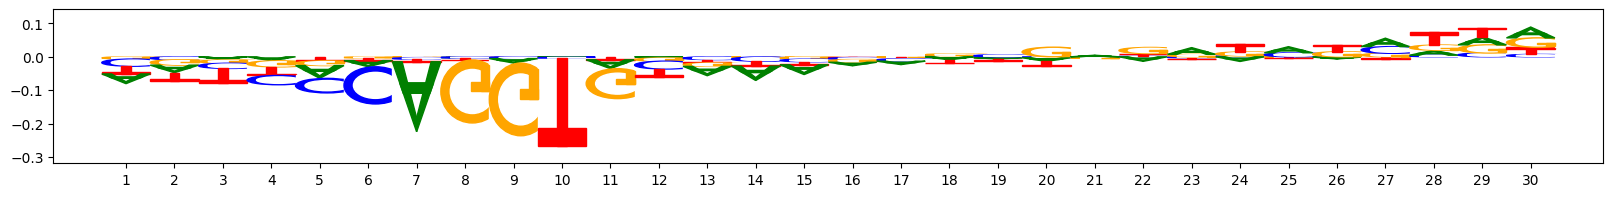

numseqlets: 85


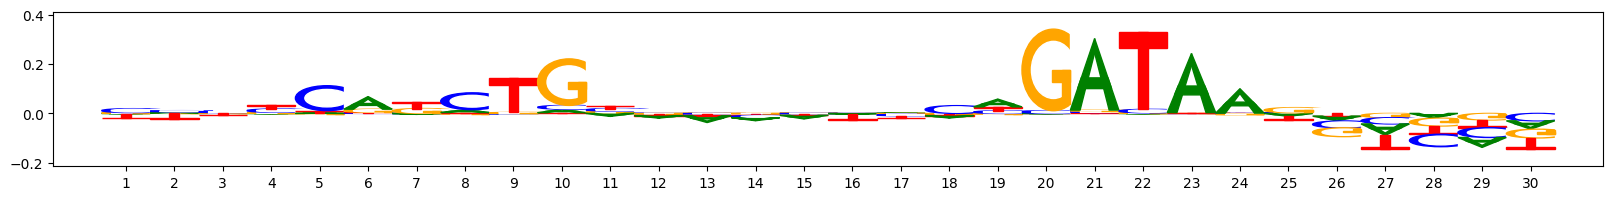

numseqlets: 37


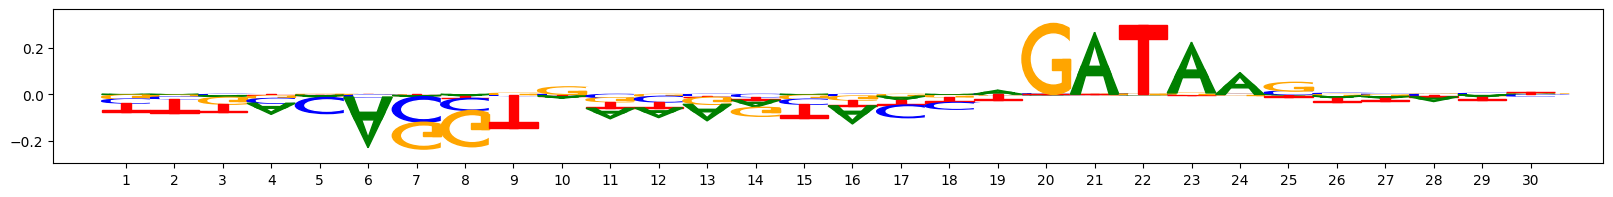

numseqlets: 35


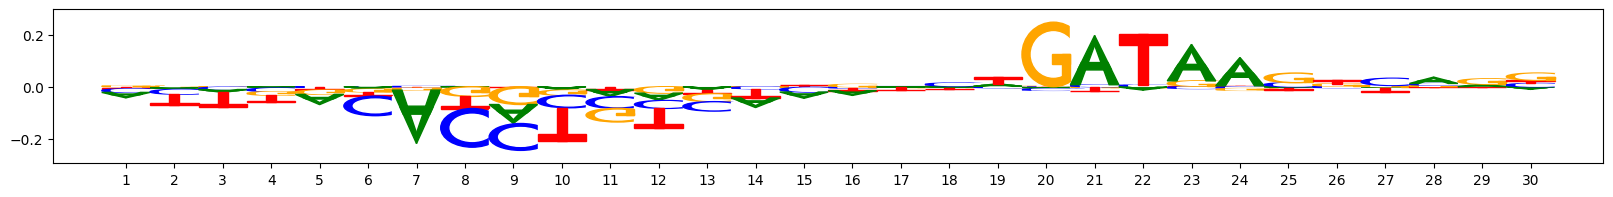

numseqlets: 27


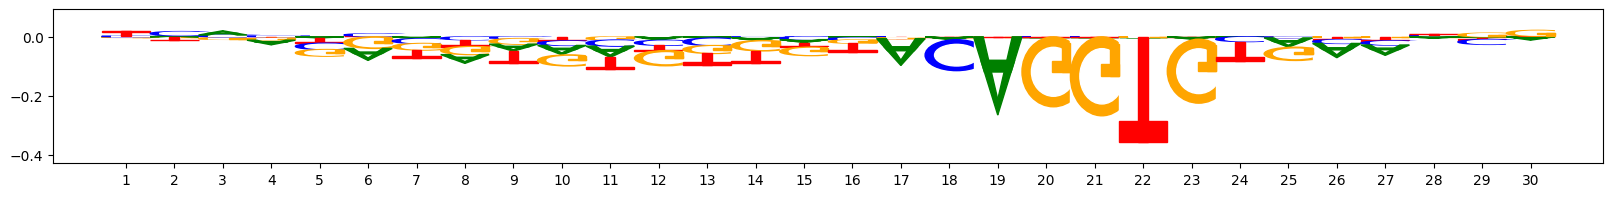

numseqlets: 24


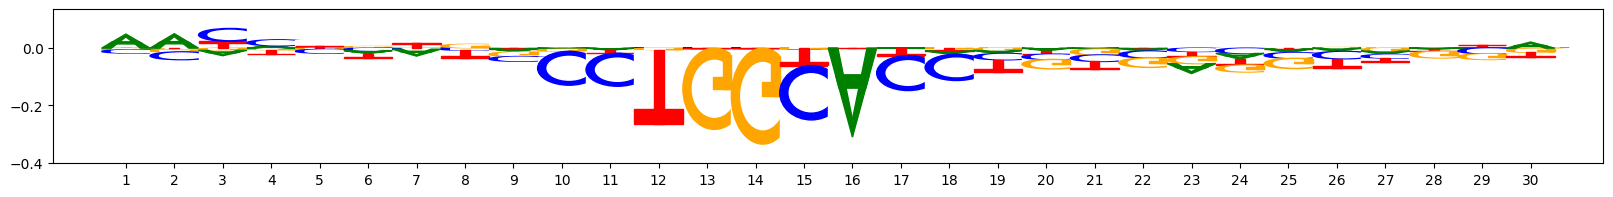

In [ ]:
%matplotlib inline
from modiscolite.aggregator import SimilarPatternsCollapser
from modiscolite.core import TrackSet, Seqlet, SeqletSet

pattern_group = 'neg_patterns' #pos_patterns or neg_patterns

#provide the list of modisco_results files to be merged, along with their
# corresponding one-hot encodings and hypothetical importance scores.
merge_list = [
    ("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_K562__100k_200.h5", "ohe.npz", "hypscores_K562.npz"),
    ("/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_HepG2__100k_200.h5", "ohe.npz", "hypscores_HepG2.npz")
]

#hyperparameters for merging - these are set
# to the defaults in tfmodisco-lite
min_overlap = 0.7
prob_and_pertrack_sim_merge_thresholds = [(0.8,0.8), (0.5, 0.85), (0.2, 0.9)]
prob_and_pertrack_sim_dealbreaker_thresholds = [(0.4, 0.75), (0.2,0.8), (0.1, 0.85), (0.0,0.9)]
min_frac = 0.2 # also called frac_support_to_trim_to
min_num = 30 # also called min_num_to_trim_to
flank_to_add = 5 # also called initial_flank_to_add
window_size = 20 # also called trim_to_window_size
max_seqlets_subsample = 300 # also called merging_max_seqlets_subsample

union_onehot = []
union_hypscores = []
union_patterncoords = []

exampleidx_offset = 0 #incremented after each modisco results file
for (results_file, onehot_file, hypscores_file) in merge_list:

  print("On file "+results_file)

  results_fh = h5.File(results_file)
  onehot = (np.load(onehot_file)["arr_0"]).transpose(0,2,1)
  hypscores = (np.load(hypscores_file)["arr_0"]).transpose(0,2,1)

  allpattern_exampleidxs = []
  #first, iterate through the patterns and get all the example indices
  # (Note: "example_idx" refers to the index of the sequence that contained
  #  the seqlet)
  for pattern_name in results_fh[pattern_group].keys():
    seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']
    allpattern_exampleidxs.extend(np.array(seqlets_grp['example_idx']))

  #figure out the subset of indices that actually have seqlets, sort it.
  surviving_indices = sorted(list(set(allpattern_exampleidxs)))
  print(str(len(surviving_indices))+" indices had seqlets out of "
        +str(len(onehot)))
  #add the scores for the subset of sequences that have scores to the
  # 'union' list.
  for idx in surviving_indices:
    union_onehot.append(onehot[idx])
    union_hypscores.append(hypscores[idx])

  #create an index remapping based on the subset of surviving indices
  # (we will add exampleidx_offset later)
  idx_remapping = dict(zip(surviving_indices,
                           np.arange(len(surviving_indices))))

  #Now iterate through the patterns again and prep the seqlet coordinates,
  # remapping the example indices as needed.
  #We also add in exampleidx_offset to account for all the previous seqeuences
  # that have already been added to the 'union' lists
  for pattern_name in results_fh[pattern_group].keys():
    seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']
    pattern_exampleidxs = np.array(seqlets_grp['example_idx'])
    #remap the example idxs
    pattern_remapped_exampleidxs = np.array([
        (exampleidx_offset+idx_remapping[idx]) for idx in pattern_exampleidxs])
    pattern_start = np.array(seqlets_grp['start'])
    pattern_end = np.array(seqlets_grp['end'])
    pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])
    union_patterncoords.append((pattern_remapped_exampleidxs,
                                pattern_start, pattern_end, pattern_isrevcomp))
  #increment exampleidx_offset
  exampleidx_offset = (exampleidx_offset + len(surviving_indices))
  results_fh.close()

#create the trackset object
union_onehot = np.array(union_onehot)
union_hypscores = np.array(union_hypscores)
track_set = TrackSet(one_hot=union_onehot,
                     contrib_scores=union_onehot*union_hypscores,
                     hypothetical_contribs=union_hypscores)

#Create pattern objects using the new track_set and modified coordinates
# print("Patterns to be merged:")
all_patterns = []
for (example_idxs, starts, ends, isrevcomps) in union_patterncoords:
  #tfmlite reuses the same object for representing seqlet
  # coordinates as well as seqlets
  seqlet_coords = [Seqlet(example_idx, start, end, isrevcomp) for
                   (example_idx, start, end, isrevcomp) in zip(
                   example_idxs, starts, ends, isrevcomps)]
  seqlets = track_set.create_seqlets(seqlet_coords)
  pattern = SeqletSet(seqlets) #SeqletSet in tfm lite = AggregatedSeqlet in tfm
  all_patterns.append(pattern)
#   print("numseqlets:",len(pattern.seqlets))
#   vizsequence.plot_weights(pattern.contrib_scores)

#bg_freq is used for identifying the region within a merged motif of
# highest information content and then expanding around that region.
bg_freq = np.mean(union_onehot, axis=(0, 1))

#Do the merging
merged_patterns, pattern_merge_hierarchy = SimilarPatternsCollapser(
    patterns=all_patterns,
    track_set=track_set,
    min_overlap=min_overlap,
    prob_and_pertrack_sim_merge_thresholds=prob_and_pertrack_sim_merge_thresholds,
	  prob_and_pertrack_sim_dealbreaker_thresholds=prob_and_pertrack_sim_dealbreaker_thresholds,
	  min_frac=min_frac,
    min_num=min_num,
    flank_to_add=flank_to_add,
    window_size=window_size,
    bg_freq=bg_freq,
	  max_seqlets_subsample=max_seqlets_subsample)

merged_pattern_scores = [pattern.contrib_scores for pattern in merged_patterns]
merged_pattern_hypscores = [pattern.hypothetical_contribs for pattern in merged_patterns]
example_idxs = [[x.example_idx for x in pattern.seqlets] for pattern in merged_patterns]
starts = [[x.start for x in pattern.seqlets] for pattern in merged_patterns]
ends = [[x.end for x in pattern.seqlets] for pattern in merged_patterns]
isrevcomps = [[x.is_revcomp for x in pattern.seqlets] for pattern in merged_patterns]

merged_patterns_dict = {'merged_pattern_scores': merged_pattern_scores,
                        'merged_pattern_hypscores': merged_pattern_hypscores,
                        'example_idxs': example_idxs,
                        'starts': starts,
                        'ends': ends,
                        'isrevcomps': isrevcomps
                            }
torch.save(merged_patterns_dict, f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_{pattern_group}.pt')

print("Merged patterns:")

for pattern in merged_patterns:
  print("numseqlets:",len(pattern.seqlets))
  vizsequence.plot_weights(pattern.contrib_scores)

##Load and trimmed merged patterns

In [ ]:
ic_threshold = 0.15

all_motif_ppms = []
all_motif_names = []
for pattern_group in ['pos_patterns', 'neg_patterns']:
    print(f'------------------------ {pattern_group} ------------------------')
    loaded_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_{pattern_group}.pt')
    for pattern_idx in range(len(loaded_pattern_dict['merged_pattern_scores'])):
        motif_name = f'{pattern_group}_{pattern_idx}'
        pattern_scores = loaded_pattern_dict['merged_pattern_scores'][pattern_idx]
        pattern_hypscores = loaded_pattern_dict['merged_pattern_hypscores'][pattern_idx]
        score_sums = pattern_scores.sum(axis=1)

        #---Plot trimmed contribution pattern
        plot_tensor = torch.Tensor(pattern_scores).T
        y_max = plot_tensor.sum(dim=0).max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xlabel('')
        plt.ylabel('Contribution')
        plt.title(motif_name, y=1.05, loc='left')
        save_path = '/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_pattern_logos/' + motif_name + '.pdf'
        plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
        plt.show()

        # plot_tensor = torch.Tensor(pattern_hypscores).T
        # y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
        # matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
        #                     axisfontscale=0.6, heightscale=0.8)
        # plt.xlabel('')
        # plt.ylabel('')
        # plt.show()

        # #---Plot heuristic motif ICM
        smooth_shape = scipy.ndimage.gaussian_filter1d(pattern_scores.std(axis=1), sigma=1)

        motif_pwm = torch.Tensor(pattern_hypscores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
        #motif_pwm = torch.Tensor(pattern_scores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
        #motif_pwm = motif_pwm * smooth_shape / smooth_shape.sum(axis=0)
        motif_pwm = motif_pwm / motif_pwm.max()
        motif_ppm = torch.softmax(5 * motif_pwm , dim=0)
        # motif_ppm = motif_ppm * torch.Tensor(smooth_shape)
        # motif_ppm = motif_ppm / motif_ppm.sum(dim=0)
        motif_icm = ppm_to_IC(motif_ppm)

        # motif_ppm = torch.Tensor(pattern_hypscores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
        # max_pos_sum = motif_ppm.sum(dim=0).max()
        # motif_ppm = motif_ppm + (max_pos_sum - motif_ppm.sum(dim=0)) * torch.softmax(10*motif_ppm, dim=0)# motif_ppm / motif_ppm.sum(dim=0) #torch.softmax(10*motif_ppm, dim=0)
        # motif_ppm = motif_ppm / max_pos_sum
        # motif_icm = ppm_to_IC(motif_ppm)

        #--- Trim icm
        ic_sums = motif_icm.sum(dim=0).tolist()

        trim_start = 0
        for i, score_sum in enumerate(ic_sums):
            if score_sum > ic_threshold:
                trim_start = i
                break
        trim_end = 0
        for i, score_sum in enumerate(reversed(ic_sums)):
            if score_sum > ic_threshold:
                trim_end = i #len(abs_score_sums) - i
                break

        motif_ppm = motif_ppm[:, trim_start:len(ic_sums) - trim_end]
        motif_icm = motif_icm[:, trim_start:len(ic_sums) - trim_end]
        motif_pwm = ppm_to_pwm(motif_ppm)

        all_motif_ppms.append(motif_ppm)
        all_motif_names.append(motif_name)

        plot_tensor = motif_icm
        try:
            y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
        except:
            y_max = plot_tensor.sum(dim=0).max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xlabel('')
        plt.ylabel('Bits')
        plt.title(motif_name, y=1.05, loc='left')
        save_path = '/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_polished_motif_logos/' + motif_name + '.pdf'
        plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
        plt.show()

        # weighted_contributions = torch.Tensor(pattern_scores).T.abs()
        # pseudo_term = torch.tensor(1e-6)
        # motif_ppm = torch.maximum(weighted_contributions, pseudo_term)
        # max_pos_sum = motif_ppm.sum(dim=0).max()
        # motif_ppm = motif_ppm + (max_pos_sum - motif_ppm.sum(dim=0)) * torch.softmax(10*motif_ppm, dim=0)# motif_ppm / motif_ppm.sum(dim=0) #torch.softmax(10*motif_ppm, dim=0)
        # motif_ppm = motif_ppm / max_pos_sum
        # motif_icm = ppm_to_IC(motif_ppm)
        # plot_tensor = motif_icm
        # y_max = plot_tensor.max()
        # matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
        #                     axisfontscale=0.6, heightscale=0.8)
        # plt.xlabel('')
        # plt.ylabel('')
        # plt.show()

        print()
    print()

Output hidden; open in https://colab.research.google.com to view.

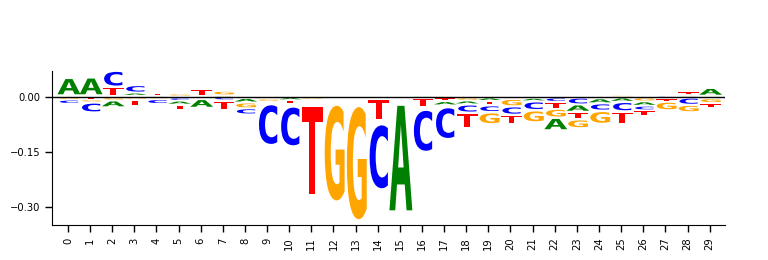

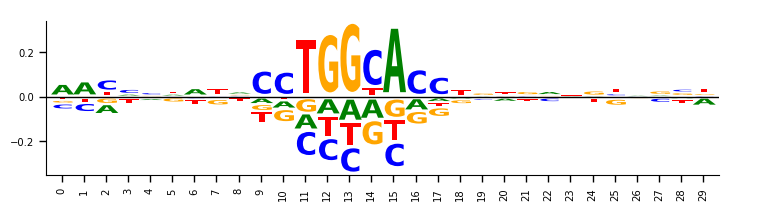

In [ ]:
# exponente = 0.1

# motif_ppm = torch.Tensor(pattern_hypscores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
# motif_ppm = (motif_ppm * (motif_ppm >= 0) )**exponente - (motif_ppm * (motif_ppm < 0) ).abs()**exponente#* motif_ppm.std(dim=0)
# max_pos_sum = motif_ppm.sum(dim=0).max()
# motif_ppm = motif_ppm + (max_pos_sum - motif_ppm.sum(dim=0)) * torch.softmax(0.5*motif_ppm, dim=0)# motif_ppm / motif_ppm.sum(dim=0) #torch.softmax(10*motif_ppm, dim=0)
# motif_ppm = motif_ppm / max_pos_sum
# motif_icm = ppm_to_IC(motif_ppm)

# motif_ppm = torch.softmax(motif_ppm, dim=0)
# motif_icm = ppm_to_IC(motif_ppm)


plot_tensor = torch.Tensor(pattern_scores).T
try:
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
except:
    y_max = plot_tensor.sum(dim=0).max()
matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                    axisfontscale=0.6, heightscale=0.8)
plt.xlabel('')
plt.ylabel('')
plt.show()

plot_tensor = torch.Tensor(pattern_hypscores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
try:
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
except:
    y_max = plot_tensor.sum(dim=0).max()
matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                    axisfontscale=0.6, heightscale=0.8)
plt.xlabel('')
plt.ylabel('')
plt.show()

#--------
# motif_pwm = torch.Tensor(pattern_hypscores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
# motif_pwm = (motif_pwm * (motif_pwm >= 0) ) + 20*(motif_pwm * (motif_pwm < 0) )
# motif_pwm = 5 * motif_pwm / motif_pwm.max()
# motif_ppm = torch.softmax(motif_pwm, dim=0)
# motif_icm = ppm_to_IC(motif_ppm)

# motif_pwm = torch.Tensor(pattern_scores).T
# motif_pwm = torch.exp(motif_pwm) / torch.exp(0.25)

# plot_tensor = motif_pwm
# try:
#     y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
# except:
#     y_max = plot_tensor.sum(dim=0).max()
# matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
#                     axisfontscale=0.6, heightscale=0.8)
# plt.xlabel('')
# plt.ylabel('')
# plt.show()

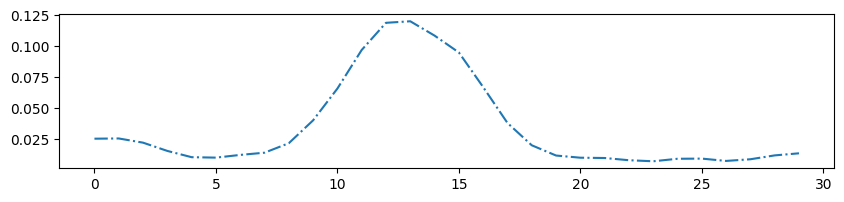

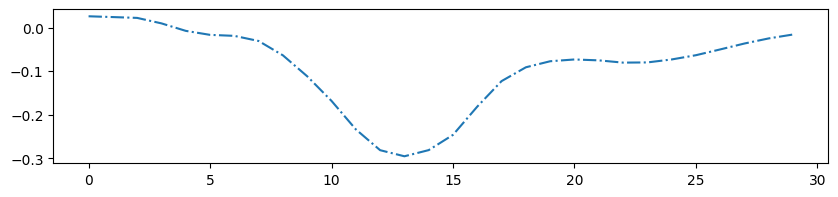

In [ ]:
smooth_shape = scipy.ndimage.gaussian_filter1d(pattern_scores.std(axis=1), sigma=1)
plt.figure(figsize=(10,2))
plt.plot(smooth_shape, linestyle='dashdot')
plt.show()

smooth_shape = scipy.ndimage.gaussian_filter1d(pattern_scores.sum(axis=1), sigma=1)
plt.figure(figsize=(10,2))
plt.plot(smooth_shape, linestyle='dashdot')
plt.show()

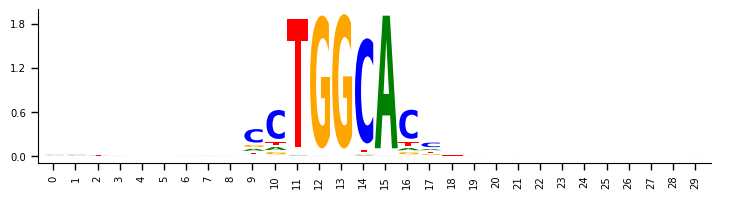

In [ ]:
# motif_ppm = torch.Tensor(pattern_scores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
# motif_ppm = motif_ppm - motif_ppm.min() + 1e-6
# motif_ppm = motif_ppm / motif_ppm.sum(dim=0)

# smooth_shape = scipy.ndimage.gaussian_filter1d(pattern_scores.std(axis=1), sigma=1)
# smooth_shape = smooth_shape / smooth_shape.max()

# # motif_ppm = motif_ppm * torch.Tensor(smooth_shape) / motif_ppm.sum(dim=0) * torch.softmax(5*motif_ppm, dim=0)
# # motif_ppm = motif_ppm / motif_ppm.max()
# # motif_ppm = torch.softmax(10*motif_ppm, dim=0)
# motif_icm = ppm_to_IC(motif_ppm)

# # max_pos_sum = motif_ppm.sum(dim=0).max()
# # motif_ppm = motif_ppm + (max_pos_sum - motif_ppm.sum(dim=0)) * torch.softmax(10*motif_ppm, dim=0)# motif_ppm / motif_ppm.sum(dim=0) #torch.softmax(10*motif_ppm, dim=0)
# # motif_ppm = motif_ppm / max_pos_sum
# # motif_icm = ppm_to_IC(motif_ppm)

smooth_shape = scipy.ndimage.gaussian_filter1d(pattern_scores.std(axis=1), sigma=2)

motif_pwm = torch.Tensor(pattern_scores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
#motif_pwm = torch.Tensor(pattern_scores * np.sign(pattern_scores.sum(axis=1)).reshape(-1, 1)).T
motif_pwm = motif_pwm * smooth_shape
motif_pwm = motif_pwm / motif_pwm.max()
motif_ppm = torch.softmax(9 * motif_pwm , dim=0)
# motif_ppm = motif_ppm * torch.Tensor(smooth_shape)
# motif_ppm = motif_ppm / motif_ppm.sum(dim=0)
motif_icm = ppm_to_IC(motif_ppm)

plot_tensor = motif_icm
y_max = plot_tensor.sum(dim=0).max()
# y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
# y_max = 2
matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                    axisfontscale=0.6, heightscale=0.8)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
def ppm_to_meme_format(ppm, motif_name):
    """
    Convert a PPM to MEME suite format.

    Args:
    ppm (numpy.ndarray): The Position Probability Matrix (PPM).
    motif_name (str): The name of the motif.

    Returns:
    str: The motif in MEME suite format.
    """
    ppm_string = f"MOTIF {motif_name}\n"
    ppm_string += f"letter-probability matrix: alength= 4 w= {ppm.shape[1]} nsites= {ppm.shape[0]}\n"

    for i in range(ppm.shape[1]):
        col = ppm[:, i]
        ppm_string += " ".join(map(str, col)) + "\n"

    return ppm_string

def write_meme_file(motif_list, motif_names, output_filename):
    """
    Write motifs to a .meme file in MEME suite format.

    Args:
    motif_list (list of numpy.ndarray): List of PPMs.
    motif_names (list of str): List of motif names.
    output_filename (str): The name of the output .meme file.
    """
    with open(output_filename, "w") as f:
        f.write("MEME version 4\n\n")
        f.write("ALPHABET= ACGT\n\n")
        f.write("strands: + -\n\n")
        f.write("Background letter frequencies:\n")
        f.write("A 0.25 C 0.25 G 0.25 T 0.25\n\n")

        for i, motif in enumerate(motif_list):
            meme_format = ppm_to_meme_format(motif, motif_names[i])
            f.write(meme_format)
            f.write("\n")

motif_list = [ppm.numpy() for ppm in all_motif_ppms]
motif_names = all_motif_names

output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_tf_modisco_polished_motifs_v1.txt"
write_meme_file(motif_list, motif_names, output_filename)

In [ ]:
score_threshold = 0.0
for pattern_group in ['pos_patterns', 'neg_patterns']:
    print(f'------------------------ {pattern_group} ------------------------')
    loaded_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_{pattern_group}.pt')
    for pattern_idx in range(loaded_pattern_dict['pos_merged_pattern_arrays'].shape[0]):
        pattern_scores = loaded_pattern_dict['pos_merged_pattern_arrays'][pattern_idx, ...]
        abs_score_sums = np.abs(pattern_scores.sum(axis=1))
        #--- Trim pattern
        trim_start = 0
        for i, score_sum in enumerate(abs_score_sums):
            if score_sum > score_threshold:
                trim_start = i
                break
        trim_end = 0
        for i, score_sum in enumerate(reversed(abs_score_sums)):
            if score_sum > score_threshold:
                trim_end = i #len(abs_score_sums) - i
                break
        trimmed_pattern_scores = pattern_scores[trim_start:len(abs_score_sums) - trim_end, :]

        #---Plot trimmed contribution pattern
        plot_tensor = torch.Tensor(trimmed_pattern_scores).T
        y_max = plot_tensor.max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xlabel('')
        plt.ylabel('')
        plt.show()

        #---Plot heuristic motif ICM
        weighted_contributions = torch.Tensor(trimmed_pattern_scores).T.abs()
        pseudo_term = torch.tensor(1e-6)
        motif_ppm = torch.maximum(weighted_contributions, pseudo_term)
        max_pos_sum = motif_ppm.sum(dim=0).max()
        motif_ppm = motif_ppm + (max_pos_sum - motif_ppm.sum(dim=0)) * torch.softmax(10*motif_ppm, dim=0)# motif_ppm / motif_ppm.sum(dim=0) #torch.softmax(10*motif_ppm, dim=0)
        motif_ppm = motif_ppm / max_pos_sum
        motif_icm = ppm_to_IC(motif_ppm)
        plot_tensor = motif_icm
        y_max = plot_tensor.max()
        matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                            axisfontscale=0.6, heightscale=0.8)
        plt.xlabel('')
        plt.ylabel('')
        plt.show()

        print()
    print()

Output hidden; open in https://colab.research.google.com to view.

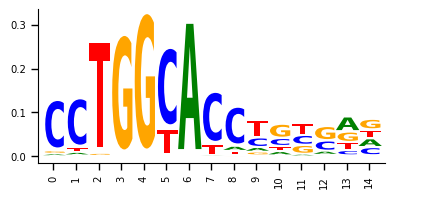

In [ ]:
plot_tensor = torch.Tensor(trimmed_pattern_scores).T.abs()
y_max = plot_tensor.max()
matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                    axisfontscale=0.6, heightscale=0.8)
plt.xlabel('')
plt.ylabel('')
plt.show()

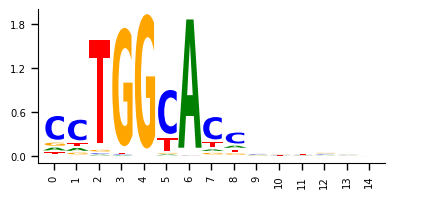

In [ ]:
weighted_contributions = torch.Tensor(trimmed_pattern_scores).T.abs()

pseudo_term = torch.tensor(1e-6)
motif_ppm = torch.maximum(weighted_contributions, pseudo_term)

max_pos_sum = motif_ppm.sum(dim=0).max()
motif_ppm = motif_ppm + (max_pos_sum - motif_ppm.sum(dim=0)) * torch.softmax(10*motif_ppm, dim=0)# motif_ppm / motif_ppm.sum(dim=0) #torch.softmax(10*motif_ppm, dim=0)
motif_ppm = motif_ppm / max_pos_sum
motif_icm = ppm_to_IC(motif_ppm)

plot_tensor = motif_icm
y_max = plot_tensor.max()
matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                    axisfontscale=0.6, heightscale=0.8)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Previous explorations

In [ ]:
cell_type = 'K562'

%matplotlib inline
fh = h5.File(f"/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_{cell_type}__100k_200.h5")

# print('Positive patterns:')
# try:
#     for akey in fh['pos_patterns'].keys():
#         vizsequence.plot_weights(fh['pos_patterns'][akey]['contrib_scores'])
# except:
#     print('No positive patterns')

# print('Negative patterns:')
# try:
#     for akey in fh['neg_patterns'].keys():
#         vizsequence.plot_weights(fh['neg_patterns'][akey]['contrib_scores'])
# except:
#     print('No negative patterns')

# fh.close()

In [ ]:
!modisco report -i /content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_K562__100k_200.h5 -o report/ -s report/ -m /content/drive/MyDrive/data/tf_motifs/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme

In [ ]:
fh['pos_patterns']['pattern_0']['seqlets'].keys()

<KeysViewHDF5 ['contrib_scores', 'end', 'example_idx', 'hypothetical_contribs', 'is_revcomp', 'n_seqlets', 'sequence', 'start']>

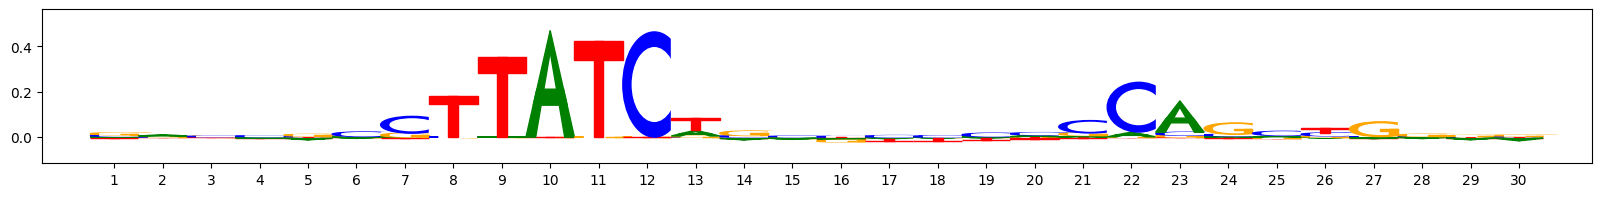

In [ ]:
vizsequence.plot_weights(fh['pos_patterns']['pattern_0']['seqlets'])

In [ ]:
fh['pos_patterns']['pattern_0']['seqlets']['n_seqlets']

<HDF5 dataset "n_seqlets": shape (1,), type "<i8">

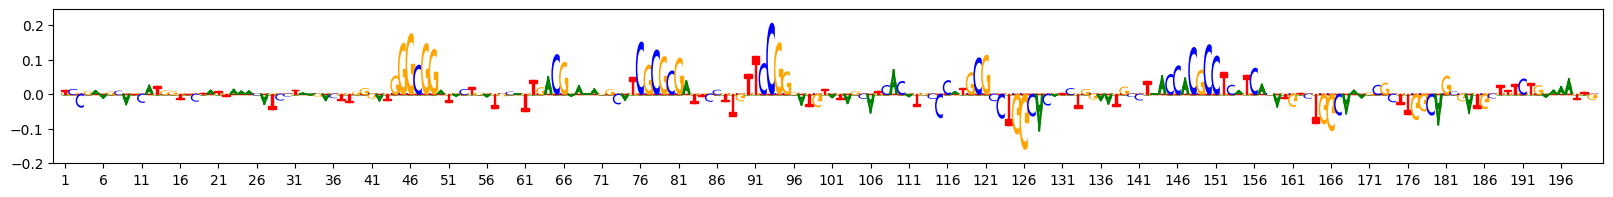

In [ ]:
vizsequence.plot_weights(contributions_dicts[cell_type]['contributions'][10466, ...].numpy())

In [ ]:
cell_type = 'K562'
results_file = f"/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/modisco_results_CODA_{cell_type}__100k_200.h5"
pattern_group = 'pos_patterns'

results_fh = h5.File(results_file)

In [ ]:
union_patterncoords = []
exampleidx_offset = 0

allpattern_exampleidxs = []
for pattern_name in results_fh[pattern_group].keys():
    seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']
    allpattern_exampleidxs.extend(np.array(seqlets_grp['example_idx']))
surviving_indices = sorted(list(set(allpattern_exampleidxs)))

print(str(len(surviving_indices))+" indices had seqlets")

idx_remapping = dict(zip(surviving_indices, np.arange(len(surviving_indices))))
for pattern_name in results_fh[pattern_group].keys():
    seqlets_grp = results_fh[pattern_group][pattern_name]['seqlets']
    pattern_exampleidxs = np.array(seqlets_grp['example_idx'])
    #remap the example idxs
    pattern_remapped_exampleidxs = np.array([
        (exampleidx_offset+idx_remapping[idx]) for idx in pattern_exampleidxs])
    pattern_start = np.array(seqlets_grp['start'])
    pattern_end = np.array(seqlets_grp['end'])
    pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])
    union_patterncoords.append((pattern_remapped_exampleidxs,
                                pattern_start, pattern_end, pattern_isrevcomp))

15835 indices had seqlets


In [ ]:
union_patterncoords[0]

(array([ 7208,  9156,  8612, ...,  2332,  3405, 14304]),
 array([137,  68, 140, ...,  26,  24,  62]),
 array([167,  98, 170, ...,  56,  54,  92]),
 array([ True,  True,  True, ..., False, False,  True]))

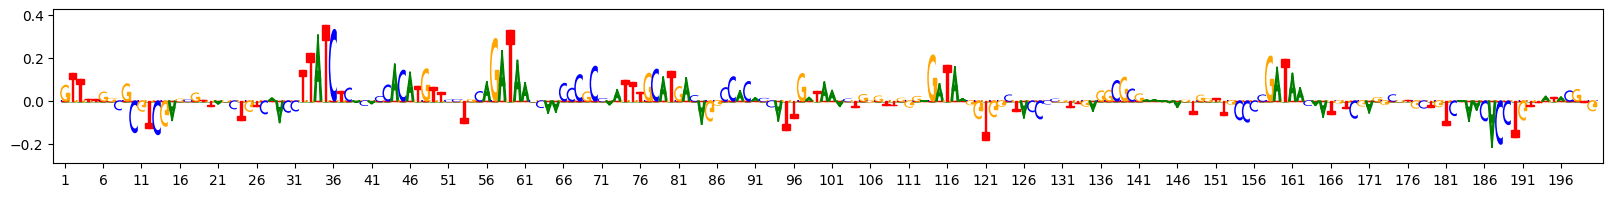

In [ ]:
vizsequence.plot_weights(contributions_dicts[cell_type]['contributions'][16698, ...].numpy())

In [ ]:
for i, pattern_name in enumerate(results_fh[pattern_group].keys()):
    print(i, pattern_name)

0 pattern_0
1 pattern_1
2 pattern_10
3 pattern_11
4 pattern_12
5 pattern_13
6 pattern_14
7 pattern_15
8 pattern_16
9 pattern_17
10 pattern_18
11 pattern_19
12 pattern_2
13 pattern_20
14 pattern_21
15 pattern_22
16 pattern_23
17 pattern_24
18 pattern_25
19 pattern_26
20 pattern_27
21 pattern_3
22 pattern_4
23 pattern_5
24 pattern_6
25 pattern_7
26 pattern_8
27 pattern_9


In [ ]:
idx_inv_remapping = dict(zip(np.arange(len(surviving_indices)), surviving_indices))

In [ ]:
idx_inv_remapping[3405]

16698

In [ ]:
seqlets_grp = results_fh[pattern_group]['pattern_0']['seqlets']

seq_ids = np.array(seqlets_grp['example_idx'])
starts = np.array(seqlets_grp['start'])
ends = np.array(seqlets_grp['end'])
pattern_isrevcomp = np.array(seqlets_grp['is_revcomp'])


In [ ]:
results_fh[pattern_group]['pattern_0'].keys()

<KeysViewHDF5 ['contrib_scores', 'hypothetical_contribs', 'seqlets', 'sequence', 'subpattern_0', 'subpattern_1', 'subpattern_10', 'subpattern_11', 'subpattern_12', 'subpattern_13', 'subpattern_14', 'subpattern_15', 'subpattern_16', 'subpattern_17', 'subpattern_18', 'subpattern_19', 'subpattern_2', 'subpattern_20', 'subpattern_3', 'subpattern_4', 'subpattern_5', 'subpattern_6', 'subpattern_7', 'subpattern_8', 'subpattern_9']>

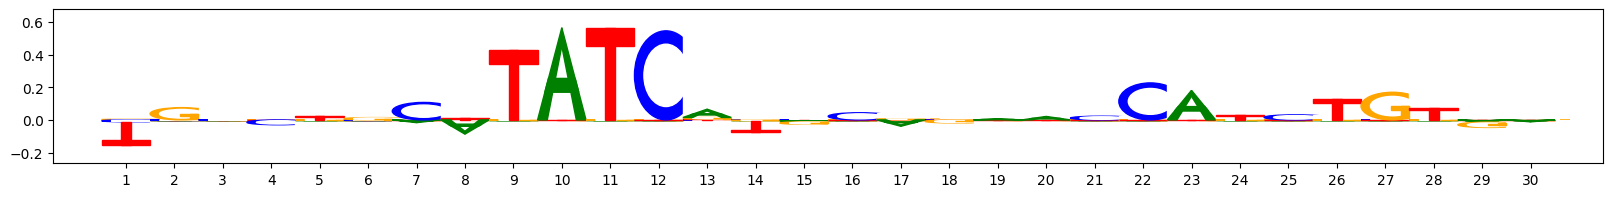

In [ ]:
vizsequence.plot_weights(results_fh[pattern_group]['pattern_0']['subpattern_20']['contrib_scores'])